## __EDA FOR QUERY 1 Weaning__

__Team members:__ Khushank Sethi, Daniel Vargas, Anna Dorosehva and Karina Bautista

The following code is designed to perform Exploratory Data Analysis (EDA) on MIMIC-IV database (version 4), which was acquired through Physionet under a special license. The __primary objective__ of this project to develop a reliable model for predicting weaning success in patients with sepsis, as well as to identify the key variables that are associated with the development of this diagnostic.

Target: Weaning Success (WS) as:
- The patient didn’t need to go back on a breathing tube (intubation) or another form of mechanical ventilation (like a ventilator) within 48 hours after being taken off.
- The patient didn’t die within 48 hours after being weaned off the ventilator.
    
If the patient needed noninvasive ventilation (like a CPAP machine), it had to be for less than 48 hours after weaning.

### __Table of Contents__

__Data Collection__
1. [Features description](#features-description)

__Data Preprocessing (EDA)__

2. [Missing Values](#missing-values)
3. [Valid Range](#valid-range)
4. [Outliers](#outliers)
5. [Distribution](#distribution)
6. [Correlation](#correlation)
7. [Normality Check](#normality-check)
8. [Multicollinearity](#multicollinearity)
9. [Balance Data Check](#balance-data-check)

 __Data Processing__

10. [Train/Test Split](#train-and-test)
11. [XGBoost Logistic](#xgboost-logistic)
12. [Random Forest](#random-forest)
13. [PCA](#PCA)
14. [GridSearch](#gridsearch)
15. [SHAP](#SHAP)

__4. Evaluation__

15. [Accuracy, Precision, F1 Score and F1 Scores](#results)
16. [Conclusion](#final-results)
17.  [References](#references)


Before proceeding with the Exploratory Data Analysis (EDA), let's import the necessary libraries.

In [1]:
import pandas as pd
import numpy as np          
import matplotlib.pyplot as plt 
import seaborn as sns         
import scipy.stats as stats   
import warnings  
import sklearn 
from scipy.stats import shapiro 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant  
import math
from sklearn.ensemble import RandomForestClassifier  
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
import xgboost as xgb  
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
import shap
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*use_label_encoder.*")
#import missingno as msno    

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### __Features Description__

In [2]:
dfq1 = pd.read_csv('/Users/karibautista/Desktop/DANA 4830/Team work/Query 1/Weaning.csv')
dfq1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34035 entries, 0 to 34034
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   subject_id                  34035 non-null  int64  
 1   stay_id                     34035 non-null  int64  
 2   age                         34035 non-null  int64  
 3   gender                      34035 non-null  object 
 4   bmi                         24056 non-null  float64
 5   charlson_comorbidity_index  34035 non-null  int64  
 6   chronic_pulmonary_disease   34035 non-null  int64  
 7   congestive_heart_failure    34035 non-null  int64  
 8   dementia                    34035 non-null  int64  
 9   severe_liver_disease        34035 non-null  int64  
 10  renal_disease               34035 non-null  int64  
 11  rheumatic_disease           34035 non-null  int64  
 12  diabetes                    34035 non-null  int64  
 13  gcs_total                   256

| **Variable**                 | **Description**                                           | **Valid Range** | **Units** |
|------------------------------|-----------------------------------------------------------|-----------------|-----------|
| subject_id                   | Unique identifier for each patient                        | Integer         | N/A       |
| stay_id                      | Unique identifier for each ICU stay                      | Integer         | N/A       |
| age                          | Patient's age at ICU admission                           | 0 – 120         | Years     |
| gender                       | Patient's gender (Male/Female)                           | Male/Female     | N/A       |
| bmi                          | Body Mass Index (BMI)                                    | 18.5 – 30       | kg/m2     |
| charlson_comorbidity_index   | Charlson comorbidity index (measures comorbidity burden) | Integer         | N/A       |
| chronic_pulmonary_disease    | Presence of chronic pulmonary disease                    | 0 = No, 1 = Yes | N/A       |
| congestive_heart_failure     | Presence of congestive heart failure                     | 0 = No, 1 = Yes | N/A       |
| dementia                     | Presence of dementia                                     | 0 = No, 1 = Yes | N/A       |
| severe_liver_disease         | Presence of severe liver disease                         | 0 = No, 1 = Yes | N/A       |
| renal_disease                | Presence of renal disease                                | 0 = No, 1 = Yes | N/A       |
| rheumatic_disease            | Presence of rheumatic disease                            | 0 = No, 1 = Yes | N/A       |
| diabetes                     | Presence of diabetes                                     | 0 = No, 1 = Yes | N/A       |
| gcs_total                    | Glasgow Coma Scale (GCS) - Assesses consciousness level | 3 – 15           | N/A       |
| max_wbc                      | Maximum white blood cell count                           | 0 – 30          | mEq/L     |
| max_hemoglobin               | Maximum hemoglobin level                                 | 0 – 20          | g/dL      |
| max_platelets                | Maximum platelet count                                   | 0 – 1000        | 10^3/μL   |
| max_creatinine               | Maximum creatinine level                                 | 0 – 400          | µmol/L   |
| max_anion_gap                | Maximum anion gap (measures acid-base balance)           | 0 – 30          | mEq/L     |
| min_wbc                      | Minimum white blood cell count                           | 0 – 100000      | cells/μL  |
| min_hemoglobin               | Minimum hemoglobin level                                 | 10 – 30         | g/dL     |
| min_platelets                | Minimum platelet count                                   | 0 – 1000        | 10^3/μL   |
| min_creatinine               | Minimum creatinine level                                 | 0 – 400          | µmol/L   |
| min_anion_gap                | Minimum anion gap                                        | 0 – 30          | mEq/L     |
| max_hr                       | Maximum heart rate                                       | 40 – 200        | bpm       |
| max_map                      | Maximum mean arterial pressure                           | 40 – 200        | mmHg      |
| max_resp_rate                | Maximum respiratory rate                                 | 10 – 50         | breaths/min|
| max_spo2                     | Maximum blood oxygen saturation                          | 0 – 100         | %         |
| max_temp                     | Maximum body temperature                                 | 60 – 100         | °F       |
| min_hr                       | Minimum heart rate                                       | 40 – 200        | bpm       |
| min_map                      | Minimum mean arterial pressure                           | 40 – 200        | mmHg      |
| min_resp_rate                | Minimum respiratory rate                                 | 10 – 50         | breaths/min|
| min_spo2                     | Minimum blood oxygen saturation                          | 0 – 100         | %         |
| min_temp                     | Minimum body temperature                                 | 60 – 100        | °F        |
| duration_imv_hours           | Duration of invasive mechanical ventilation (IMV) in hours| 0 – 1000        | Hours     |
| duration_niv_hours           | Duration of non-invasive ventilation (NIV) in hours      | 0 – 1000        | Hours     |
| duration_other_niv_hours     | Duration of other forms of non-invasive ventilation in hours | 0 – 1000     | Hours     |
| weaning_success              | Indicator of successful weaning from mechanical ventilation (1 = Success, 0 = Failure) | 0, 1          | N/A       |

Let's see if we have duplicates:

In [3]:
# Count how many subject_id values are duplicated (without including the first occurrence)
duplicate_subject_id_count_inclusive = dfq1['subject_id'].duplicated(keep='first').sum()
print(f"Number of subject_id values with duplicates (including the first occurrence): {duplicate_subject_id_count_inclusive}")

Number of subject_id values with duplicates (including the first occurrence): 9155


Since we have duplicated rows, we must eliminate the duplicates:

In [4]:
# Keep only the unique subject_id rows (first occurrence of each)
dfq1_cleaned = dfq1.drop_duplicates(subset='subject_id', keep='first')

duplicate_count_after = dfq1_cleaned['subject_id'].duplicated().sum()
print(f"Number of duplicate subject_id values after keeping only unique subject_ids: {duplicate_count_after}")


Number of duplicate subject_id values after keeping only unique subject_ids: 0


In [5]:
dfq1_cleaned.shape

(24880, 38)

In addition, let's visualize the distribution of the variables before doing any changes.

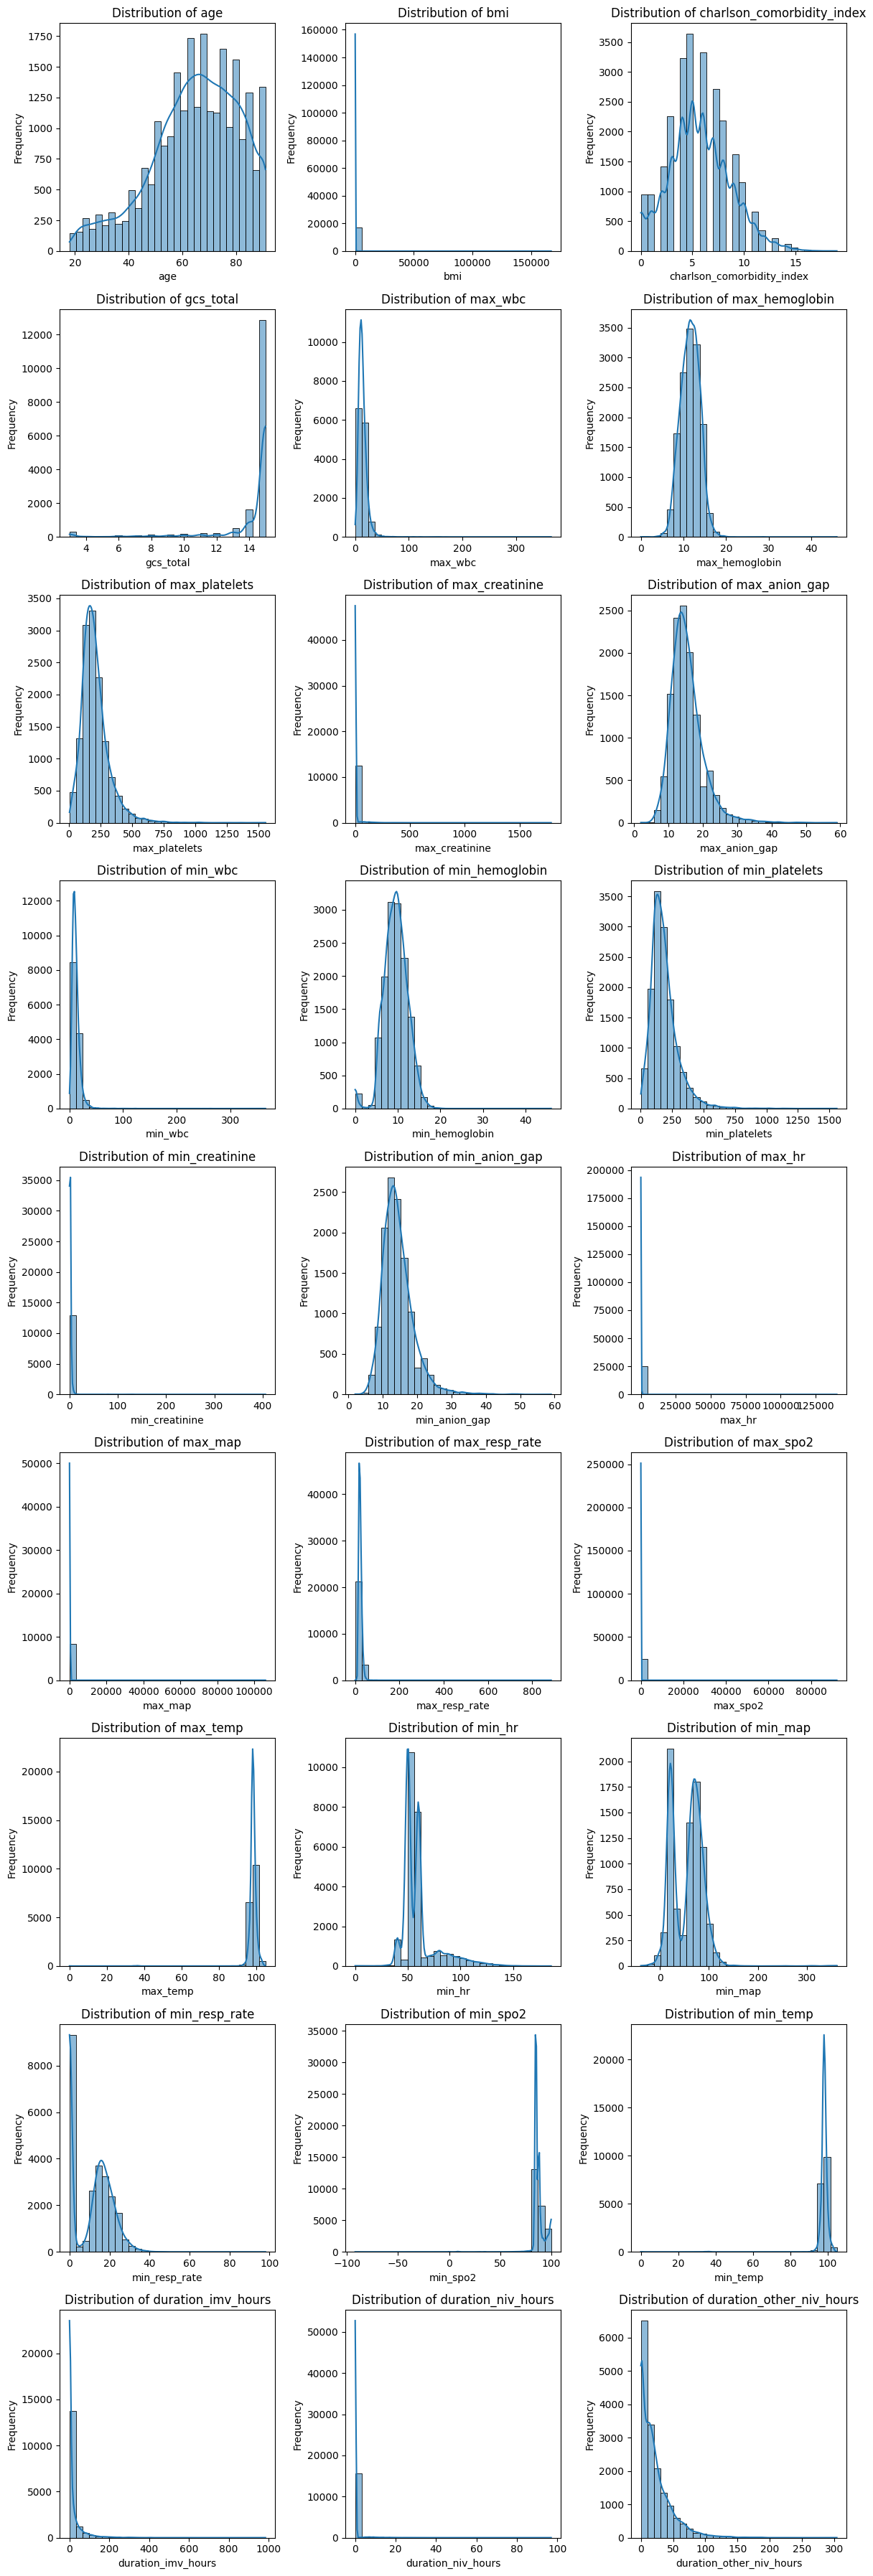

In [6]:
columns_to_exclude = [
    'subject_id', 'stay_id', 'chronic_pulmonary_disease', 'congestive_heart_failure', 
    'dementia', 'severe_liver_disease', 'renal_disease', 'rheumatic_disease', 'diabetes', 
    'weaning_success']

numerical_columns = dfq1_cleaned.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = [col for col in numerical_columns if col not in columns_to_exclude]

columns_to_check = [col for col in numerical_columns if col not in columns_to_exclude]

n_cols = 3  
n_rows = int(np.ceil(len(columns_to_check) / n_cols))
plt.figure(figsize=(12, 4 * n_rows))
for i, column in enumerate(columns_to_check, 1):
    plt.subplot(n_rows, n_cols, i)  # Adjust rows and columns based on the number of columns
    sns.histplot(dfq1_cleaned[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Now we can start with the EDA

### __Missing Values__

In [7]:
print(dfq1_cleaned.isnull().sum())
missing_values = dfq1_cleaned.isnull().sum() / len(dfq1_cleaned) * 100
missing_values = missing_values[missing_values > 0] 
missing_values.sort_values(ascending=False)

subject_id                        0
stay_id                           0
age                               0
gender                            0
bmi                            7963
charlson_comorbidity_index        0
chronic_pulmonary_disease         0
congestive_heart_failure          0
dementia                          0
severe_liver_disease              0
renal_disease                     0
rheumatic_disease                 0
diabetes                          0
gcs_total                      8347
max_wbc                       11458
max_hemoglobin                10763
max_platelets                 11405
max_creatinine                11934
max_anion_gap                 12525
min_wbc                       11458
min_hemoglobin                10763
min_platelets                 11405
min_creatinine                11934
min_anion_gap                 12525
max_hr                            3
max_map                       16463
max_resp_rate                   254
max_spo2                    

min_map                     66.169614
max_map                     66.169614
max_anion_gap               50.341640
min_anion_gap               50.341640
max_creatinine              47.966238
min_creatinine              47.966238
max_wbc                     46.053055
min_wbc                     46.053055
max_platelets               45.840032
min_platelets               45.840032
max_hemoglobin              43.259646
min_hemoglobin              43.259646
duration_other_niv_hours    35.309486
duration_niv_hours          35.309486
duration_imv_hours          35.309486
gcs_total                   33.549035
bmi                         32.005627
max_temp                    29.216238
min_temp                    29.216238
min_spo2                     2.073955
max_spo2                     2.073955
min_resp_rate                1.020900
max_resp_rate                1.020900
min_hr                       0.012058
max_hr                       0.012058
dtype: float64

For imputation, we could potentially base our approach on the following plot, which will help us visualize any differences between the means of the variables and the target variable. By examining this, we might uncover patterns or relationships that could guide the imputation strategy.

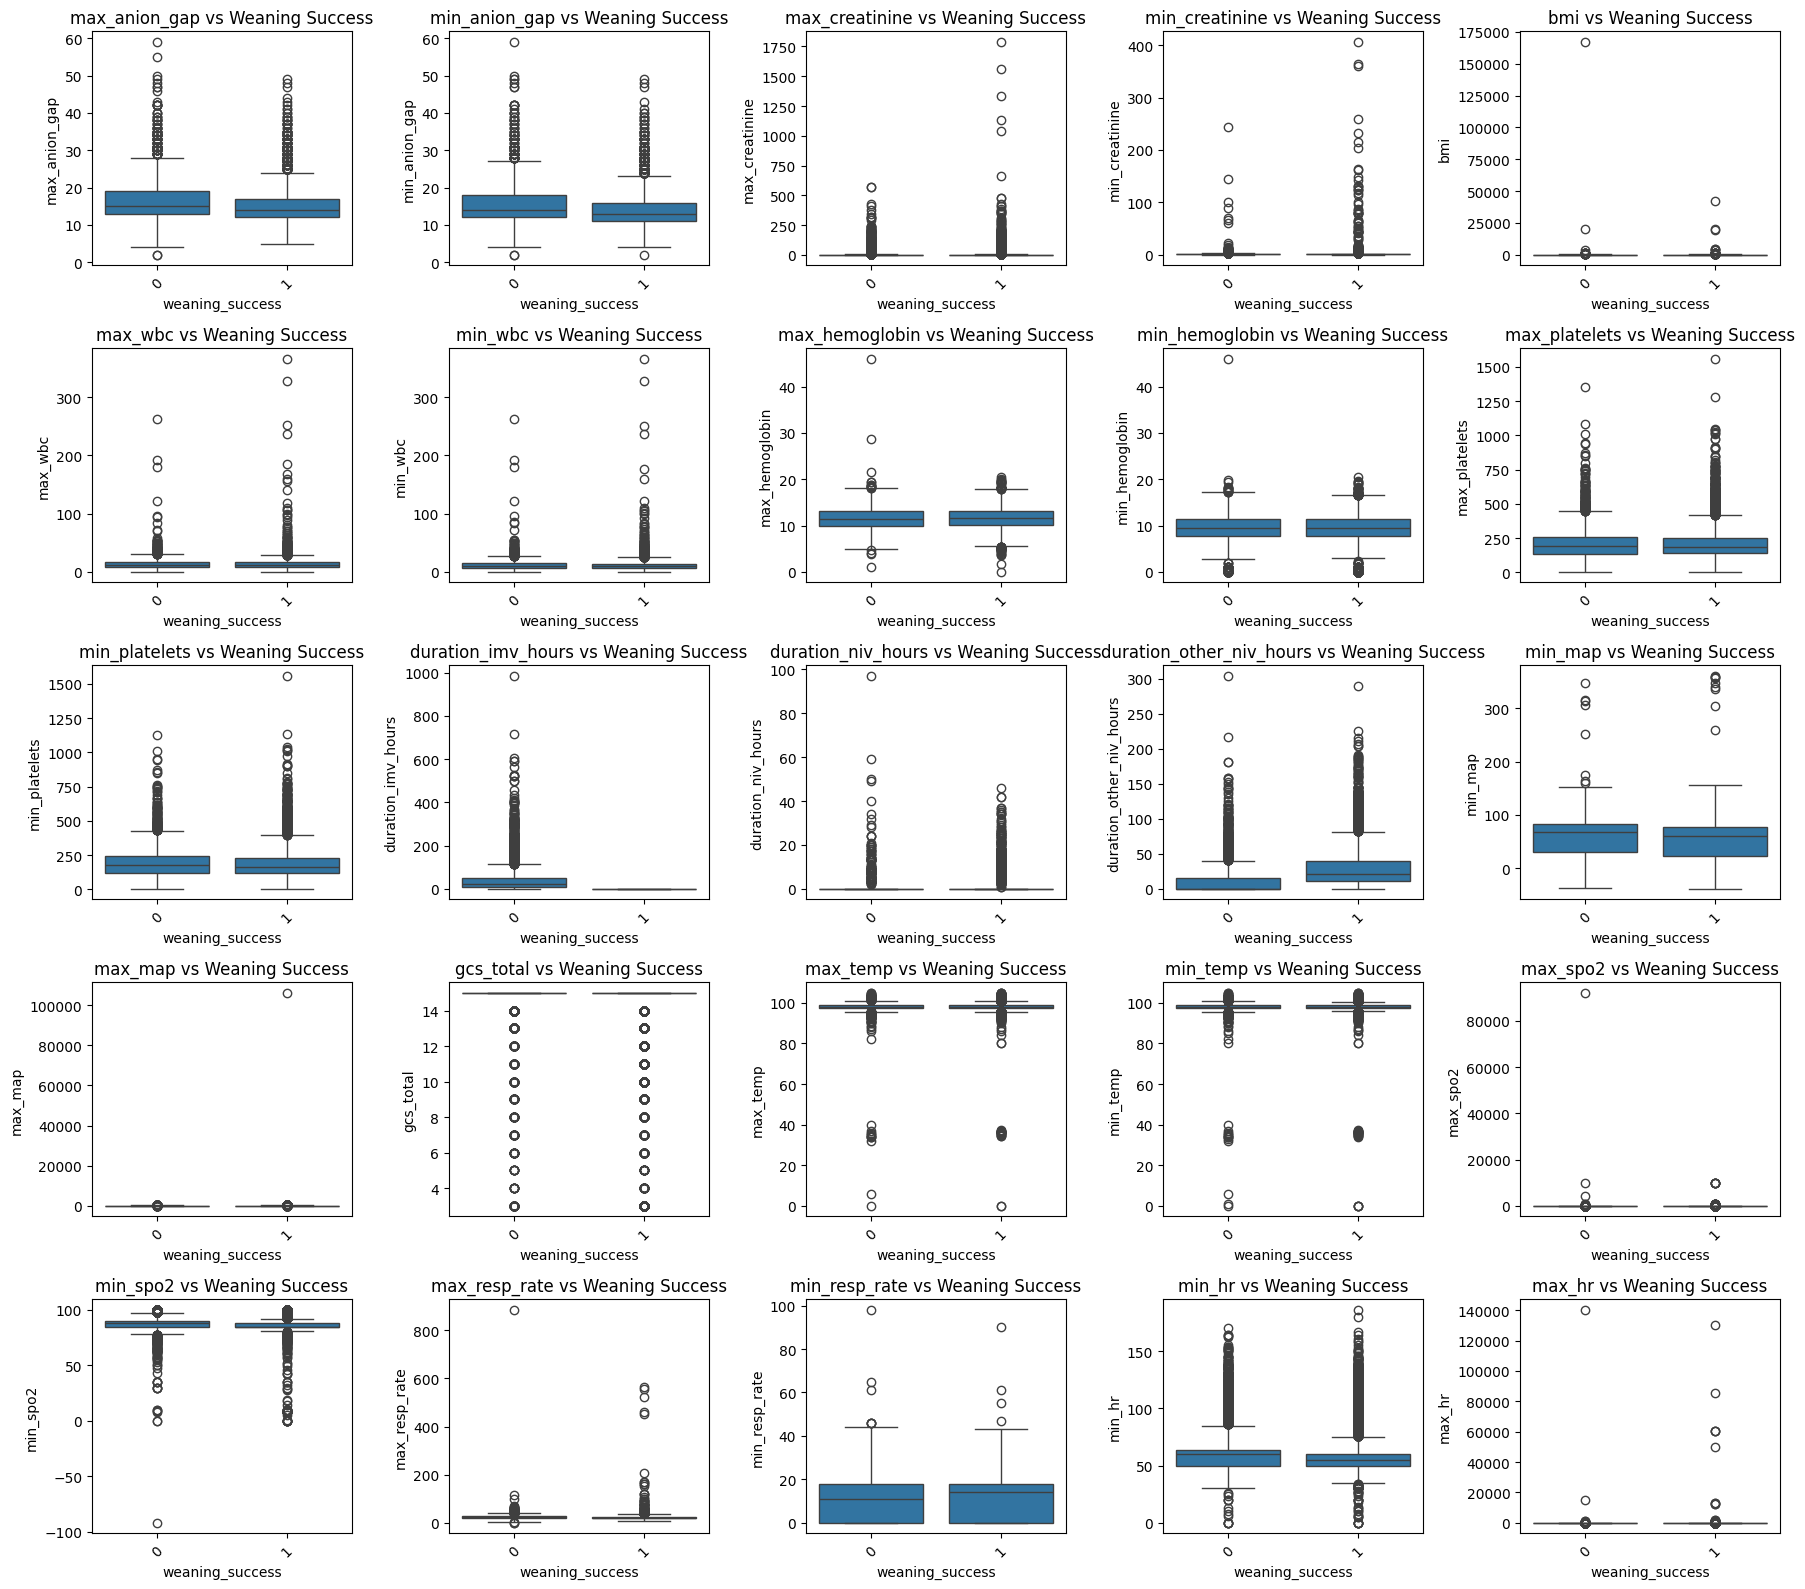

In [8]:
# List of continuous variables you want to visualize
continuous_vars = ['max_anion_gap', 'min_anion_gap', 'max_creatinine', 'min_creatinine',
                   'bmi', 'max_wbc', 'min_wbc', 'max_hemoglobin', 'min_hemoglobin', 
                   'max_platelets', 'min_platelets', 'duration_imv_hours', 'duration_niv_hours',
                   'duration_other_niv_hours', 'min_map', 'max_map', 'gcs_total', 'max_temp',
                   'min_temp', 'max_spo2', 'min_spo2', 'max_resp_rate', 'min_resp_rate', 
                   'min_hr', 'max_hr']

plt.figure(figsize=(18, 16))

# Loop through continuous variables and create box plots
for i, var in enumerate(continuous_vars, 1):
    plt.subplot(5, 5, i)  # 5 rows, 5 columns (adjust as needed)
    sns.boxplot(x='weaning_success', y=var, data=dfq1_cleaned)  # Box plot to compare distribution by weaning_success
    plt.title(f'{var} vs Weaning Success')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

There is __no__ significant difference in the mean between patients in the categories 0 and 1. 

For columns with __less than 30%__ missing values, we will impute the missing data using the __median__.

In [9]:
columns_to_impute = ['max_temp', 'min_temp', 'max_spo2', 'min_spo2', 
                     'max_resp_rate', 'min_resp_rate', 'min_hr', 'max_hr'] # List of columns to impute with the median

dfq1_cleaned = dfq1_cleaned.copy() 

for column in columns_to_impute: # Impute missing values in these columns with the median
    median_value = dfq1_cleaned[column].median() 
    dfq1_cleaned.loc[:, column] = dfq1_cleaned[column].fillna(median_value)  
missing_values = dfq1_cleaned[columns_to_impute].isna().sum()
print(missing_values)

max_temp         0
min_temp         0
max_spo2         0
min_spo2         0
max_resp_rate    0
min_resp_rate    0
min_hr           0
max_hr           0
dtype: int64


For __BMI__, we will categorize the data into age groups (e.g., 18-29, 30-39, etc.) and visualize the distribution of BMI across these groups using a box plot.

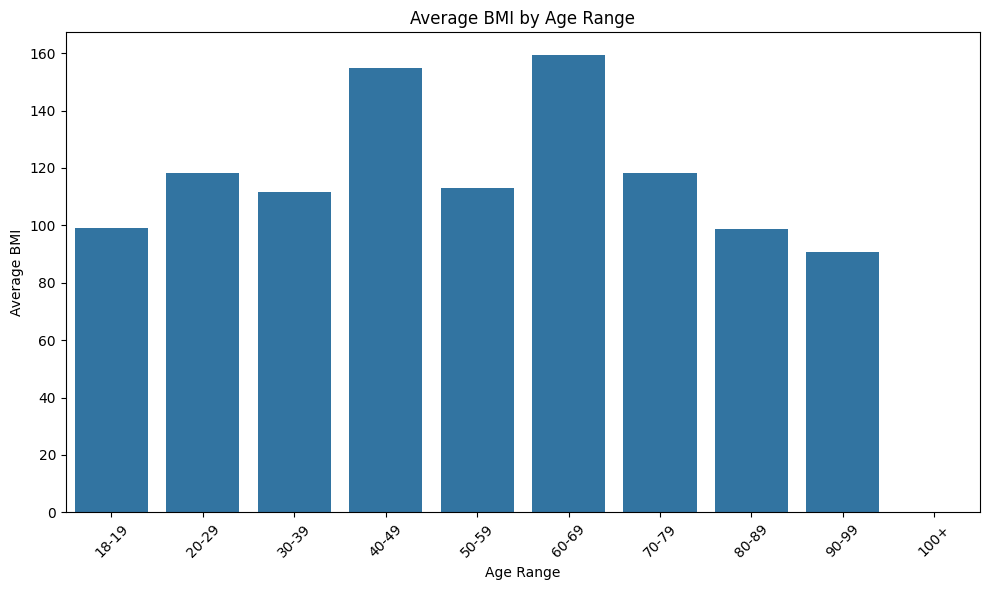

In [10]:
# Create age bins starting from 18
age_bins = [18, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]  # Start from 18
age_labels = ['18-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100+']

# Bin the 'age' column into these ranges
dfq1_cleaned['age_group'] = pd.cut(dfq1_cleaned['age'], bins=age_bins, labels=age_labels, right=False)

# Group by the 'age_group' and calculate the mean BMI for each age range
age_bmi_group = dfq1_cleaned.groupby('age_group', observed=False)['bmi'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='bmi', data=age_bmi_group)

# Add labels and title
plt.xlabel('Age Range')
plt.ylabel('Average BMI')
plt.title('Average BMI by Age Range')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

There is likely to be an __outlier__, which we will address in the outliers section. 

However, let's first create the boxplot without considering the outliers to examine if there is a noticeable difference in BMI across age groups.

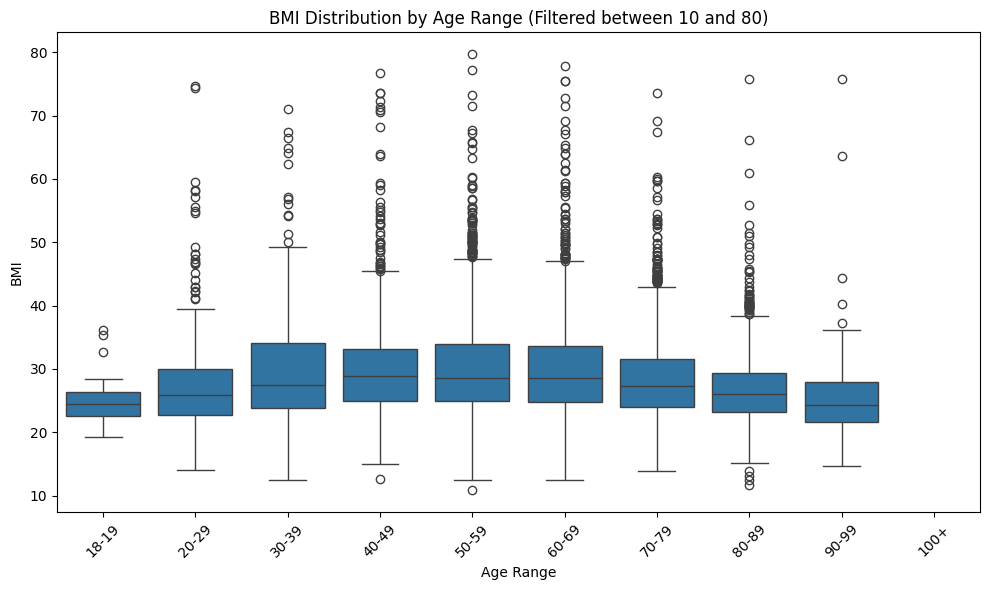

In [11]:
# Filter the data to include only BMI values between 10 and 80
dfq1_cleaned_filtered = dfq1_cleaned[(dfq1_cleaned['bmi'] >= 10) & (dfq1_cleaned['bmi'] <= 80)]

plt.figure(figsize=(10, 6))
sns.boxplot(x='age_group', y='bmi', data=dfq1_cleaned_filtered)
plt.xlabel('Age Range')
plt.ylabel('BMI')
plt.title('BMI Distribution by Age Range (Filtered between 10 and 80)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Since the mean and median varies, we plan to calculate the mean BMI for each age group and use these __median__ values to impute any missing BMI data within their respective age ranges.

In [12]:
# Bin the 'age' column into these ranges
dfq1_cleaned['age_group'] = pd.cut(dfq1_cleaned['age'], bins=age_bins, labels=age_labels, right=False)

# Calculate the mean BMI for each age group
median_bmi_per_age_group = dfq1_cleaned.groupby('age_group', observed=False)['bmi'].median()

# Impute missing BMI values with the mean BMI for the respective age group
def impute_bmi(row):
    if pd.isnull(row['bmi']):
        return median_bmi_per_age_group[row['age_group']]
    else:
        return row['bmi']

# Apply the impute_bmi function to the dataset
dfq1_cleaned['bmi'] = dfq1_cleaned.apply(impute_bmi, axis=1)
print(f"Number of missing values for bmi: {(dfq1_cleaned['bmi'].isnull().sum())}")

Number of missing values for bmi: 0


For the other approach, let's explore a different method for imputation. So, let's visualize the __correlation__ between the numerical variables

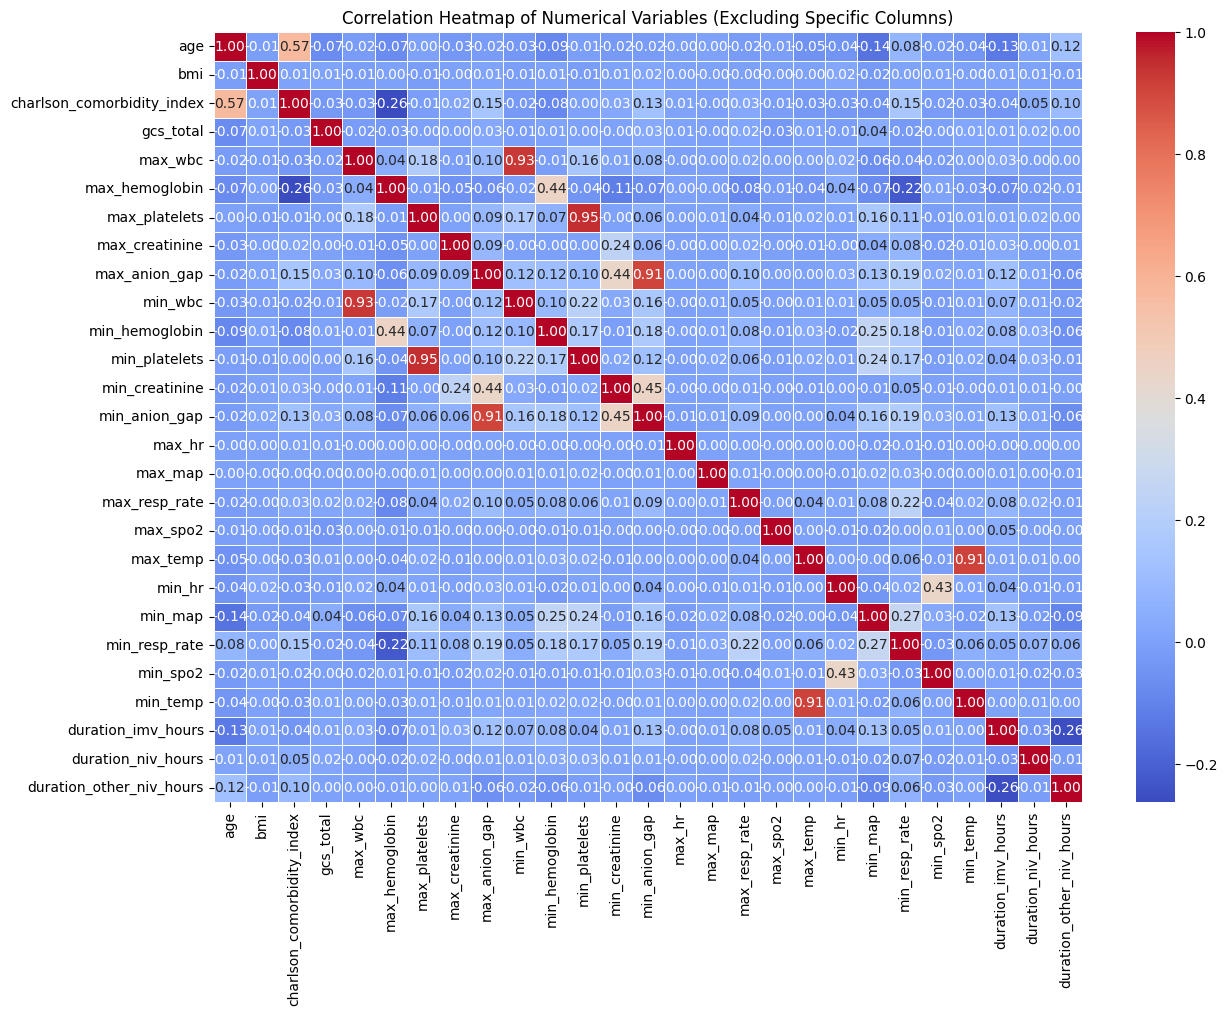

In [13]:
# List of columns to exclude

correlation_matrix = dfq1_cleaned[numerical_columns].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Variables (Excluding Specific Columns)')
plt.show()

The relationship between the variables is weak, making them unsuitable for imputation. Thus we continue.

For __gcs_total__ , we calculate the mean and median:

In [14]:
mean_gcs_total = dfq1_cleaned['gcs_total'].mean()
median_gcs_total = dfq1_cleaned['gcs_total'].median()
print(f"Mean of GCS Total: {mean_gcs_total}")
print(f"Median of GCS Total: {median_gcs_total}")

Mean of GCS Total: 14.220891550232867
Median of GCS Total: 15.0


To know if we should impute it with the median or mean, let's take a look of the variable distribution:

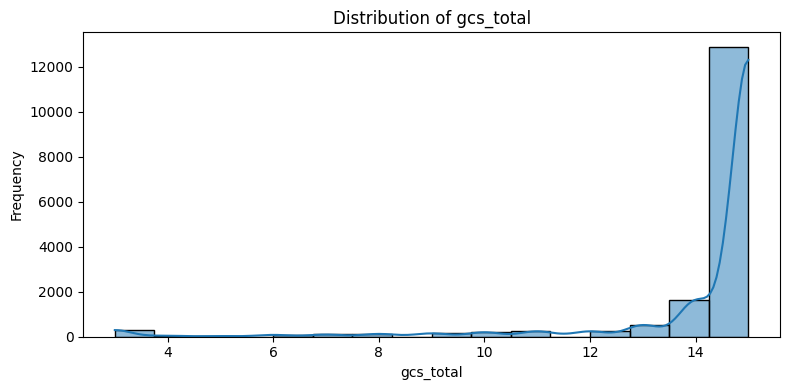

In [15]:
plt.figure(figsize=(8, 4))
sns.histplot(dfq1_cleaned['gcs_total'], kde=True)
plt.title('Distribution of gcs_total')
plt.xlabel('gcs_total')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Since the distribution of __gcs_total__ is __left-skewed__, this indicates that there are many lower values in the dataset, with a few higher values pulling the mean to the right. In such cases, the mean is influenced by the extreme values, and imputation using the mean might not accurately represent the typical value for missing data. Thus, we will impute it with the __median__:

In [16]:
dfq1_cleaned['gcs_total'] = dfq1_cleaned['gcs_total'].fillna(median_gcs_total)
print(dfq1_cleaned['gcs_total'].isnull().sum())

0


For the columns __duration_other_niv_hours, duration_niv_hours, and duration_imv_hours__, the patients included in the dataset were required to undergo a ventilation procedure. Let’s now determine how many patients lack this data.

In [17]:
# Count rows where any of the specified columns have missing (NaN) values
count_missing_rows = dfq1_cleaned[dfq1_cleaned[['duration_other_niv_hours', 'duration_niv_hours', 'duration_imv_hours']].isna().any(axis=1)].shape[0]
print(count_missing_rows)

8785


Since there are 8,785 patients who do not have this data, we cannot remove them.

However, we can see that some patients have zero in the three types of ventilation. Example:

| duration_imv_hours | duration_niv_hours | duration_other_niv_hours |
|--------------------|---------------------|---------------------------|
| 0                  | 0                   | 0                         |
| 0                  | 0                   | 0                         |
| 0                  | 0                   | 0                         |
| 0                  | 0                   | 0                         |

So we are going to assume that the missing values will be replace by __zero__.

In [18]:
ventilation_columns = ['duration_imv_hours', 'duration_niv_hours', 'duration_other_niv_hours']
dfq1_cleaned[ventilation_columns] = dfq1_cleaned[ventilation_columns].fillna(0)

print(dfq1_cleaned[ventilation_columns].isna().sum())

duration_imv_hours          0
duration_niv_hours          0
duration_other_niv_hours    0
dtype: int64


For __max_creatinine and min_creatinine__ 

We are goint to try to impute it with the help of dataset 2, because we have some shared columns so maybe the data is complete. So if the subject_id matches with the dataset 2, it will look into the column creatinene (in dataset 2) and if there is a value there bring it to the min_creatinine and max_creatinine cell. So let's try and do it:

In [19]:
dfq2 = pd.read_csv('/Users/karibautista/Desktop/DANA 4830/Team work/Query 2/Sepsis.csv')
# Merge dfq1_cleaned with dfq2 based on 'subject_id' to bring the 'creatinine' values
merged_df = dfq1_cleaned.merge(dfq2[['subject_id', 'creatinine']], on='subject_id', how='left')

# Impute missing values in 'min_creatinine' and 'max_creatinine' using the 'creatinine' column from dfq2
merged_df['min_creatinine'] = merged_df['min_creatinine'].fillna(merged_df['creatinine'])
merged_df['max_creatinine'] = merged_df['max_creatinine'].fillna(merged_df['creatinine'])

# Now drop the 'creatinine' column as it was only used for imputation
dfq1_cleaned_updated = merged_df.drop(columns=['creatinine'])

missing_min_creatinine = dfq1_cleaned_updated['min_creatinine'].isna().mean() * 100
missing_max_creatinine = dfq1_cleaned_updated['max_creatinine'].isna().mean() * 100
print(f"Percentage of missing values in 'min_creatinine': {missing_min_creatinine:.2f}%")
print(f"Percentage of missing values in 'max_creatinine': {missing_max_creatinine:.2f}%")

Percentage of missing values in 'min_creatinine': 46.77%
Percentage of missing values in 'max_creatinine': 46.77%


However, the reduction in missing values was minimal.

Let's try the same method for __max_hemoglobin and min_hemoglobin__

In [20]:
# Merge dfq1_cleaned with dfq2 based on 'subject_id' to bring the 'hemoglobin' values
merged_df = dfq1_cleaned.merge(dfq2[['subject_id', 'hemoglobin']], on='subject_id', how='left')

# Impute missing values in 'min_hemoglobin' and 'max_hemoglobin' using the 'hemoglobin' column from dfq2
merged_df['min_hemoglobin'] = merged_df['min_hemoglobin'].fillna(merged_df['hemoglobin'])
merged_df['max_hemoglobin'] = merged_df['max_hemoglobin'].fillna(merged_df['hemoglobin'])

# Now drop the 'hemoglobin' column as it was only used for imputation
dfq1_cleaned_updated = merged_df.drop(columns=['hemoglobin'])

missing_min_hemoglobin = dfq1_cleaned_updated['min_hemoglobin'].isna().mean() * 100
missing_max_hemoglobin = dfq1_cleaned_updated['max_hemoglobin'].isna().mean() * 100
print(f"Percentage of missing values in 'min_hemoglobin': {missing_min_hemoglobin:.2f}%")
print(f"Percentage of missing values in 'max_hemoglobin': {missing_max_hemoglobin:.2f}%")

Percentage of missing values in 'min_hemoglobin': 42.15%
Percentage of missing values in 'max_hemoglobin': 42.15%


Got the same result.

For __min_wbc__ and __max_wbc__:

In [21]:
# Merge dfq1_cleaned with dfq2 based on 'subject_id' to bring the 'white_blood_cells' values
merged_df = dfq1_cleaned.merge(dfq2[['subject_id', 'white_blood_cells']], on='subject_id', how='left')

# Impute missing values in 'min_wbc' and 'max_wbc' using the 'white_blood_cells' column from dfq2
merged_df['min_wbc'] = merged_df['min_wbc'].fillna(merged_df['white_blood_cells'])
merged_df['max_wbc'] = merged_df['max_wbc'].fillna(merged_df['white_blood_cells'])

# Now drop the 'white_blood_cells' column as it was only used for imputation
dfq1_cleaned_updated = merged_df.drop(columns=['white_blood_cells'])

# Verify the result
missing_min_wbc = dfq1_cleaned_updated['min_wbc'].isna().mean() * 100
missing_max_wbc = dfq1_cleaned_updated['max_wbc'].isna().mean() * 100
print(f"Percentage of missing values in 'min_wbc': {missing_min_wbc:.2f}%")
print(f"Percentage of missing values in 'max_wbc': {missing_max_wbc:.2f}%")

Percentage of missing values in 'min_wbc': 44.86%
Percentage of missing values in 'max_wbc': 44.86%


Since none of the imputation methods were successful. We are going to use the __KNN imputation__ for the following variables:

In [22]:
missing_values = dfq1_cleaned_updated.isnull().sum() / len(dfq1_cleaned) * 100
missing_values = missing_values[missing_values > 0] 
missing_values.sort_values(ascending=False)

max_map           66.169614
min_map           66.169614
max_anion_gap     50.341640
min_anion_gap     50.341640
max_creatinine    47.966238
min_creatinine    47.966238
max_platelets     45.840032
min_platelets     45.840032
max_wbc           44.859325
min_wbc           44.859325
max_hemoglobin    43.259646
min_hemoglobin    43.259646
dtype: float64

In [23]:
columns_to_impute = [
    'max_map', 'min_map', 'max_anion_gap', 'min_anion_gap', 
    'max_creatinine', 'min_creatinine', 'max_platelets', 
    'min_platelets', 'max_wbc', 'min_wbc', 
    'max_hemoglobin', 'min_hemoglobin']

# Create an instance of the KNN imputer
imputer = KNNImputer(n_neighbors=5) 

# Select only the columns you want to impute
df_to_impute = dfq1_cleaned_updated[columns_to_impute]

# Apply the KNN imputer to the selected columns
df_imputed = imputer.fit_transform(df_to_impute)

# Replace the original columns with the imputed values
dfq1_cleaned_updated[columns_to_impute] = df_imputed
print(dfq1_cleaned_updated[columns_to_impute].isnull().sum())

max_map           0
min_map           0
max_anion_gap     0
min_anion_gap     0
max_creatinine    0
min_creatinine    0
max_platelets     0
min_platelets     0
max_wbc           0
min_wbc           0
max_hemoglobin    0
min_hemoglobin    0
dtype: int64


### __Outliers__

In [24]:
dfq1_cleaned_updated.shape

(24880, 39)

Let's visualize the boxplots to identify outliers amongst our numerical variables

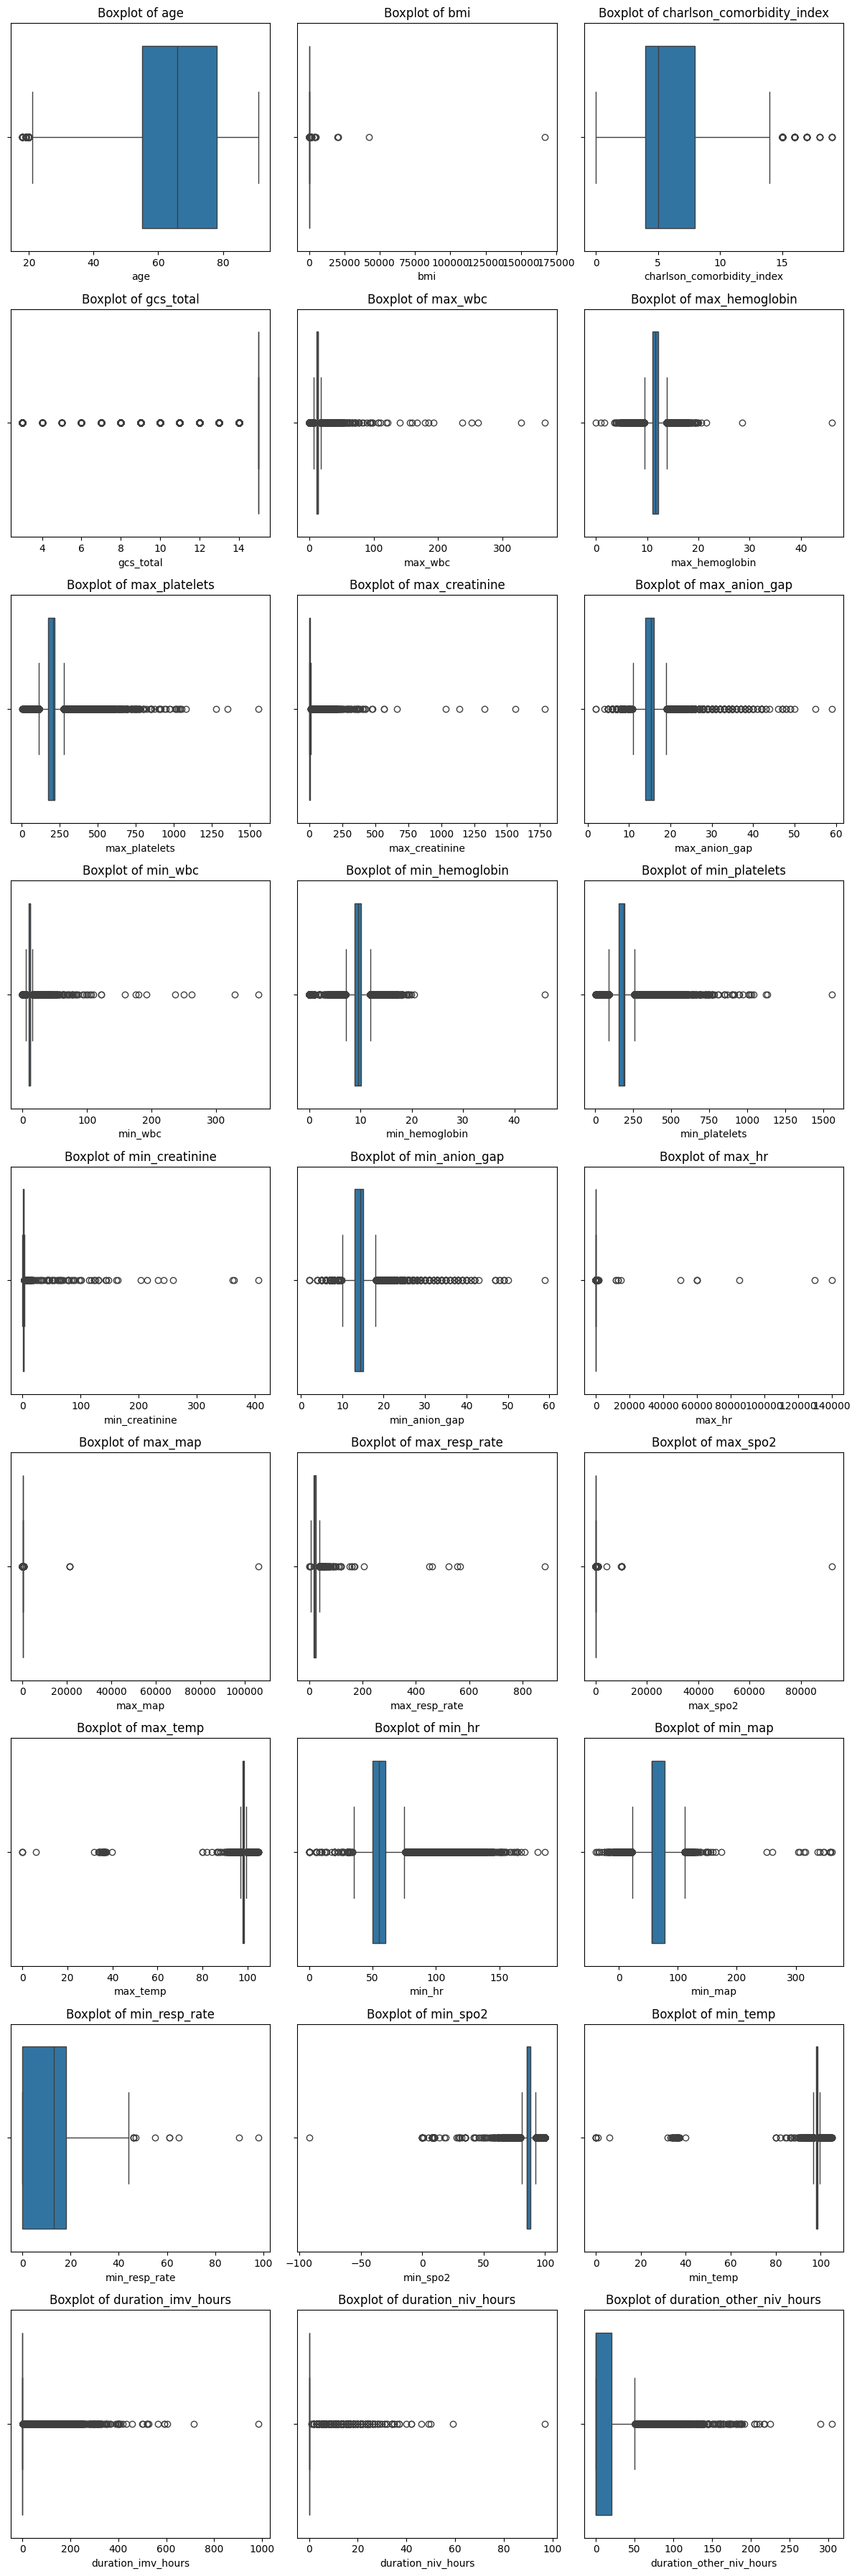

In [25]:
numerical_columns = dfq1_cleaned_updated.select_dtypes(include=['float64', 'int64']).columns # Select numerical columns to check for outliers

# Calculate the number of rows and columns for the subplot grid
num_columns = len(columns_to_check)
num_rows = math.ceil(num_columns / 3)  # 3 columns per row

plt.figure(figsize=(12, num_rows * 4))
for i, col in enumerate(columns_to_check, 1):
    plt.subplot(num_rows, 3, i)  # Adjust the number of rows and columns automatically
    sns.boxplot(data=dfq1_cleaned_updated, x=col)
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

The following variables are accurate and do not need any changes:
- age 
- gcs_total
- duration_imv_hours
- duration_niv_hours
- duration_other_niv_hours
- charlson_comorbidity_index
- min_wbc
- max_wbc

A __BMI__ (Body Mass Index) range of 1300 is unrealistic. The typical range for BMI is between 10 and 100 (depending on the population), with most values falling between 15 and 50 for adults. Thus, we considered a valid rane of 10-80, and for the ones that are outside this range will be removed.

First, let's see how many patients are outside this valid range:

In [26]:
# Count the observations where BMI is less than or equal to 10 or greater than 80
count_bmi_outliers = dfq1_cleaned_updated[(dfq1_cleaned_updated['bmi'] <= 10) | (dfq1_cleaned_updated['bmi'] > 80)].shape[0]
print(f"Number of observations with BMI <= 10 or BMI > 80: {count_bmi_outliers}")

Number of observations with BMI <= 10 or BMI > 80: 11981


Since 11,981 observations are outside the expected range, we cannot remove these patients. Instead, we will adjust the values: if the BMI is less than 10, it will be replaced with 10, and if it exceeds 80, it will be capped at 80.

In [27]:
dfq1_cleaned_updated['bmi'] = dfq1_cleaned_updated['bmi'].apply(lambda x: 10 if x <= 10 else (80 if x > 80 else x))
bmi_min = dfq1_cleaned_updated['bmi'].min()
bmi_max = dfq1_cleaned_updated['bmi'].max()
print(f"New Minimum BMI: {bmi_min}")
print(f"New Maximum BMI: {bmi_max}")

New Minimum BMI: 10.0
New Maximum BMI: 80.0


The __respiratory rate__ (the number of breaths taken per minute) generally falls within a more defined range, and values between 0 and 100 are unrealistic in most cases. It cannot be zero, since the person would be implying that is dead.
- Normal respiratory rate for a healthy adult at rest: 12 to 20 breaths per minute.
- Tachypnea (rapid breathing): > 20 breaths per minute.
- Bradypnea (slow breathing): < 12 breaths per minute.
- Severe respiratory distress or abnormal cases may cause the respiratory rate to go above 30-40 breaths per minute.

So for those values that are more than 50 in the variables __max_resp_rate__ and __min_resp_rate__, let's replace them with 50 and those values less than 12, will be replaced with 12.

In [28]:
dfq1_cleaned_updated['max_resp_rate'] = dfq1_cleaned_updated['max_resp_rate'].apply(lambda x: 50 if x > 50 else (12 if x < 12 else x))
dfq1_cleaned_updated['min_resp_rate'] = dfq1_cleaned_updated['min_resp_rate'].apply(lambda x: 50 if x > 50 else (12 if x < 12 else x))
print(dfq1_cleaned_updated[['max_resp_rate', 'min_resp_rate']].describe())

       max_resp_rate  min_resp_rate
count   24880.000000   24880.000000
mean       22.416921      15.686616
std         6.461281       4.963614
min        12.000000      12.000000
25%        18.000000      12.000000
50%        21.000000      13.000000
75%        26.000000      18.000000
max        50.000000      50.000000


For __max_spo2__ and __min_spo2__, the maximum value that max_spo2 can reach (in terms of a typical or reasonable range for blood oxygen saturation) is generally 100%, as this value represents the highest possible level of oxygen saturation in the blood.

In medical contexts, a 100% SpO2 indicates that all the hemoglobin in the blood is fully saturated with oxygen, which is considered a normal and healthy level. So if the values are more than 100, we will replace with 100. And for the negative values with zero

In [29]:
print(dfq1_cleaned_updated[['max_spo2', 'min_spo2']].describe()) # Look the min and max

           max_spo2      min_spo2
count  24880.000000  24880.000000
mean     106.689349     87.690193
std      607.374213      6.182813
min       29.000000    -92.000000
25%      100.000000     85.000000
50%      100.000000     85.000000
75%      100.000000     88.000000
max    92100.000000    100.000000


In [30]:
dfq1_cleaned_updated['max_spo2'] = dfq1_cleaned_updated['max_spo2'].apply(lambda x: 100 if x > 100 else (0 if x < 0 else x))
dfq1_cleaned_updated['min_spo2'] = dfq1_cleaned_updated['min_spo2'].apply(lambda x: 100 if x > 100 else (0 if x < 0 else x))
print(dfq1_cleaned_updated[['max_spo2', 'min_spo2']].describe())

           max_spo2      min_spo2
count  24880.000000  24880.000000
mean      99.602291     87.693891
std        1.714448      6.102329
min       29.000000      0.000000
25%      100.000000     85.000000
50%      100.000000     85.000000
75%      100.000000     88.000000
max      100.000000    100.000000


For the __temperature__, at around 70°F (21°C), the body enters a critical state, and brain function becomes severely impaired.
Below 70°F (21°C) is considered near-fatal or potentially fatal for most individuals.
- Human Survival Limit: 50°F (10°C) is considered the lowest recorded body temperature where someone has survived after being found in a hypothermic state. This was an exceptional case of a person surviving after being submerged in icy water. For this data, we are going to consider the lowest 60, and the maximum 105.

In [31]:
dfq1_cleaned_updated['max_temp'] = dfq1_cleaned_updated['max_temp'].apply(lambda x: 105 if x > 105 else (60 if x < 60 else x))
dfq1_cleaned_updated['min_temp'] = dfq1_cleaned_updated['min_temp'].apply(lambda x: 105 if x > 105 else (60 if x < 60 else x))
print(dfq1_cleaned_updated[['max_temp', 'min_temp']].describe())

           max_temp      min_temp
count  24880.000000  24880.000000
mean      98.236391     98.147775
std        1.831490      1.902447
min       60.000000     60.000000
25%       97.900000     97.800000
50%       98.200000     98.200000
75%       98.600000     98.500000
max      104.900000    104.900000


For __max_hr__ and __min_hr__  a maximum heart rate of 800 bpm is not possible or healthy. The highest maximum heart rate, even for a highly fit individual, is typically around 200 bpm, with the estimate being 220.

In [32]:
print(dfq1_cleaned_updated[['max_hr', 'min_hr']].describe())

              max_hr        min_hr
count   24880.000000  24880.000000
mean      144.032074     60.030788
std      1525.326348     17.592420
min         0.000000      0.000000
25%       111.000000     50.000000
50%       120.000000     55.000000
75%       130.000000     60.000000
max    140110.000000    186.000000


A heart rate of 0 beats per minute (bpm) is not compatible with life and indicates cardiac arrest. In a healthy person, the heart cannot function with a heart rate of 0, as it means the heart is not beating at all, and blood is not circulating throughout the body. A heart rate below 60 bpm is considered bradycardia. While it can be normal in athletes or during sleep, in others, it may indicate problems with the heart's electrical system. Thus, we will consider a range from 40 to 200

In [33]:
dfq1_cleaned_updated['max_hr'] = dfq1_cleaned_updated['max_hr'].apply(lambda x: 200 if x > 200 else (40 if x < 40 else x))
dfq1_cleaned_updated['min_hr'] = dfq1_cleaned_updated['min_hr'].apply(lambda x: 200 if x > 200 else (40 if x < 40 else x))
print(dfq1_cleaned_updated[['max_hr', 'min_hr']].describe())

             max_hr        min_hr
count  24880.000000  24880.000000
mean     117.384646     60.103135
std       18.353068     17.461844
min       40.000000     40.000000
25%      111.000000     50.000000
50%      120.000000     55.000000
75%      130.000000     60.000000
max      200.000000    186.000000


For __max_hemoglobin__ and __min_hemoglobin__, The normal range for hemoglobin (Hb) varies based on factors such as age, sex, and the specific laboratory's reference values:
- Adult Men: 13.8 to 17.2 grams per deciliter (g/dL)
- Adult Women: 12.1 to 15.1 g/dL
- Pregnant Women: Typically, 11 to 12 g/dL is considered normal during pregnancy due to changes in blood volume.

Very high hemoglobin (e.g., > 20 g/dL) could be associated with polycythemia, chronic hypoxia, or other serious conditions.

We are going to set a range from 10 to 30.

In [34]:
dfq1_cleaned_updated['max_hemoglobin'] = dfq1_cleaned_updated['max_hemoglobin'].apply(lambda x: 30 if x > 30 else (10 if x < 10 else x))
dfq1_cleaned_updated['min_hemoglobin'] = dfq1_cleaned_updated['min_hemoglobin'].apply(lambda x: 30 if x > 30 else (10 if x < 10 else x))
print(dfq1_cleaned_updated[['max_hemoglobin', 'min_hemoglobin']].describe())

       max_hemoglobin  min_hemoglobin
count    24880.000000    24880.000000
mean        11.769026       10.509426
std          1.373262        1.171436
min         10.000000       10.000000
25%         11.100000       10.000000
50%         11.572267       10.000000
75%         12.200000       10.100000
max         30.000000       30.000000


For __min_platelets__ and __max_platelets__:
- 0 (10^3/μL): This would suggest a complete absence of platelets in the blood, which is not physiologically viable and could indicate severe thrombocytopenia or data error. A 0 value should generally be treated as an error or missing data.
- 1,500 (10^3/μL): This translates to 1,500,000 platelets/μL, which is extremely high. While high platelet counts can occur in certain medical conditions like polycythemia vera or chronic inflammation, a value this high is very rare and could also indicate a data issue.

In [35]:
# Count how many values in 'max_platelets' are >= 150 and > 500
max_platelets_above_150 = dfq1_cleaned_updated[dfq1_cleaned_updated['max_platelets'] >= 150].shape[0]
max_platelets_above_500 = dfq1_cleaned_updated[dfq1_cleaned_updated['max_platelets'] > 500].shape[0]

# Count how many values in 'min_platelets' are >= 150 and > 500
min_platelets_above_150 = dfq1_cleaned_updated[dfq1_cleaned_updated['min_platelets'] >= 150].shape[0]
min_platelets_above_500 = dfq1_cleaned_updated[dfq1_cleaned_updated['min_platelets'] > 500].shape[0]
print(f"Number of max_platelets >= 150: {max_platelets_above_150}")
print(f"Number of max_platelets > 500: {max_platelets_above_500}")
print(f"Number of min_platelets >= 150: {min_platelets_above_150}")
print(f"Number of min_platelets > 500: {min_platelets_above_500}")

Number of max_platelets >= 150: 20565
Number of max_platelets > 500: 296
Number of min_platelets >= 150: 19034
Number of min_platelets > 500: 231


The range will be from 0 to 1000.

In [36]:
dfq1_cleaned_updated['max_platelets'] = dfq1_cleaned_updated['max_platelets'].apply(lambda x: 1000 if x > 1000 else (0 if x < 0 else x))
dfq1_cleaned_updated['min_platelets'] = dfq1_cleaned_updated['min_platelets'].apply(lambda x: 1000 if x > 1000 else (0 if x < 0 else x))
print(dfq1_cleaned_updated[['max_platelets', 'min_platelets']].describe())

       max_platelets  min_platelets
count   24880.000000   24880.000000
mean      208.885222     190.543500
std        83.361966      81.415825
min         5.000000       5.000000
25%       174.000000     154.000000
50%       207.820594     189.136957
75%       214.850000     196.000000
max      1000.000000    1000.000000


For __max_creatinine__ and __min_creatinine__:
Normal range for healthy adults:
- Men: 53 to 106 µmol/L
- Women: 44 to 97 µmol/L

Mild to Moderate Kidney Impairment:
- Above 106 µmol/L (for men) or above 97 µmol/L (for women) could indicate kidney dysfunction or early-stage chronic kidney disease (CKD).

Severe Kidney Failure:
- Values greater than 250 µmol/L may indicate more significant kidney issues.

In severe kidney failure or acute renal failure, creatinine can rise significantly, often exceeding 500 µmol/L and potentially even going higher in some cases, depending on the severity of the condition. The range will we from 0 to 400.

In [37]:
dfq1_cleaned_updated['max_creatinine'] = dfq1_cleaned_updated['max_creatinine'].apply(lambda x: 400 if x > 400 else (0 if x < 0 else x))
dfq1_cleaned_updated['min_creatinine'] = dfq1_cleaned_updated['min_creatinine'].apply(lambda x: 400 if x > 400 else (0 if x < 0 else x))
print(dfq1_cleaned_updated[['max_creatinine', 'min_creatinine']].describe())

       max_creatinine  min_creatinine
count    24880.000000    24880.000000
mean         6.432428        1.833587
std         21.531850        6.640723
min          0.100000        0.000000
25%          1.000000        0.900000
50%          2.000000        1.700000
75%          6.515874        1.880092
max        400.000000      400.000000


For __max_anion_gap__ and __min_anion_gap__

An anion gap value in the range of 40–50 mEq/L is unusually high and would be considered extremely elevated. This would typically suggest a severe metabolic acidosis and could indicate serious medical conditions that require immediate attention.

Causes of a Very High Anion Gap (40-50 mEq/L):
- Severe Diabetic Ketoacidosis (DKA): In cases of uncontrolled type 1 diabetes, the body produces ketones which lead to metabolic acidosis, significantly raising the anion gap.
- Lactic Acidosis: This can occur due to conditions such as shock, sepsis, severe hypoxia, or renal failure, all of which can lead to lactic acid buildup in the blood.
- Renal Failure: Chronic kidney disease or acute renal failure can cause a high anion gap due to the accumulation of waste products in the blood.
- Toxic Ingestion: Ingestions of toxins such as methanol, ethylene glycol (antifreeze), or salicylates (aspirin) can cause a drastic increase in the anion gap.
- Starvation: Severe malnutrition or starvation can also result in ketoacidosis, which could raise the anion gap.

The range will be from 0 - 40

In [38]:
dfq1_cleaned_updated['max_anion_gap'] = dfq1_cleaned_updated['max_anion_gap'].apply(lambda x: 40 if x > 40 else (0 if x < 0 else x))
dfq1_cleaned_updated['min_anion_gap'] = dfq1_cleaned_updated['min_anion_gap'].apply(lambda x: 40 if x > 40 else (0 if x < 0 else x))
print(dfq1_cleaned_updated[['max_anion_gap', 'min_anion_gap']].describe())

       max_anion_gap  min_anion_gap
count   24880.000000   24880.000000
mean       15.468914      14.569078
std         3.459314       3.347823
min         2.000000       2.000000
25%        14.000000      13.000000
50%        15.386888      14.439579
75%        16.000000      15.000000
max        40.000000      40.000000


For __max_map__ and __min_map__:
- Normal MAP range: 70–105 mmHg
- Low MAP (< 60 mmHg): May indicate shock or insufficient perfusion.
- High MAP (> 105 mmHg): May indicate hypertension or increased cardiovascular risk.

The range we will consider is from 0 to 200.

In [39]:
dfq1_cleaned_updated['max_map'] = dfq1_cleaned_updated['max_map'].apply(lambda x: 200 if x > 200 else (0 if x < 0 else x))
dfq1_cleaned_updated['min_map'] = dfq1_cleaned_updated['min_map'].apply(lambda x: 200 if x > 200 else (0 if x < 0 else x))
print(dfq1_cleaned_updated[['max_map', 'min_map']].describe())

            max_map       min_map
count  24880.000000  24880.000000
mean      97.494031     62.190828
std       17.465235     21.478807
min        0.000000      0.000000
25%       87.800000     55.664489
50%      101.200000     55.664489
75%      105.122847     78.000000
max      200.000000    200.000000


Let's visualize the __boxplots__ again with the changes we have done:

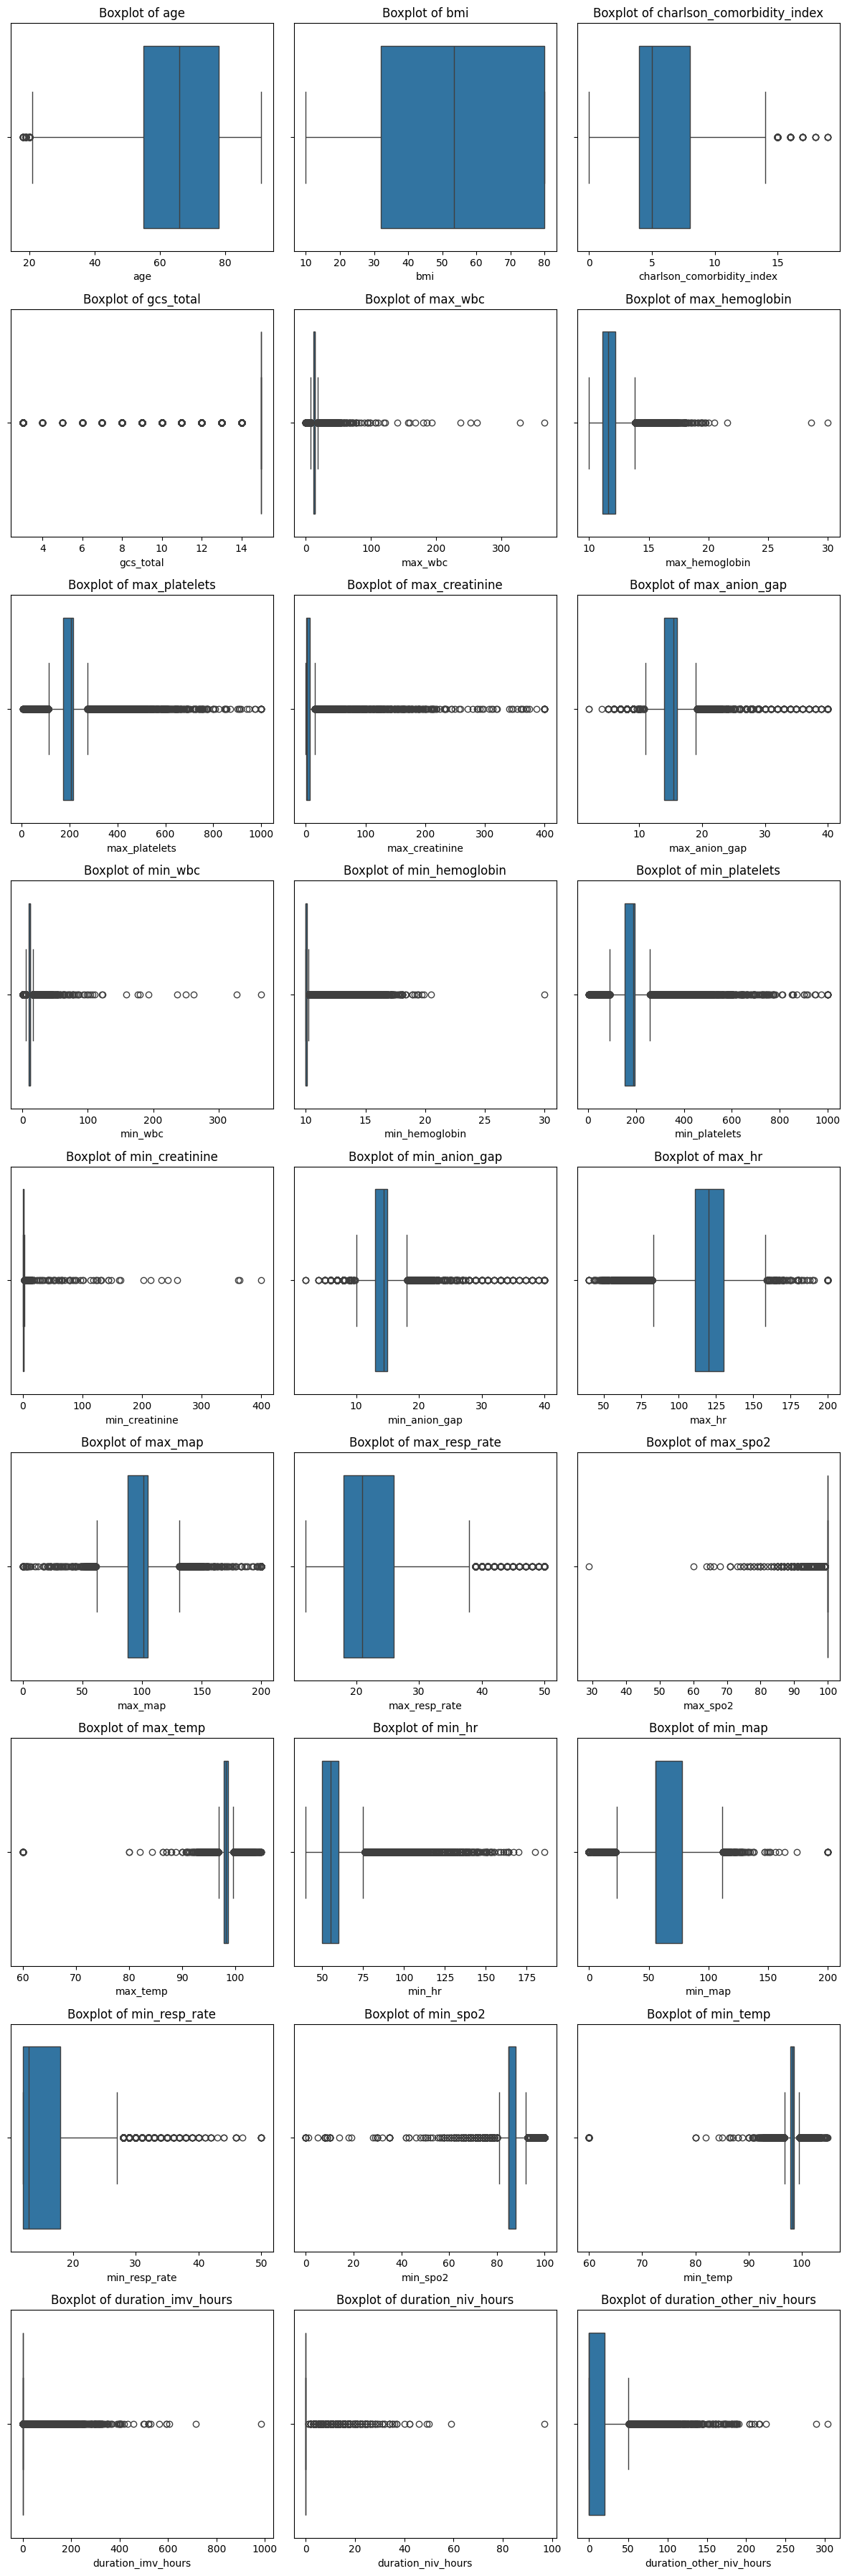

In [40]:
numerical_columns = dfq1_cleaned_updated.select_dtypes(include=['float64', 'int64']).columns

columns_to_check = [col for col in numerical_columns if col not in columns_to_exclude]

num_columns = len(columns_to_check)
num_rows = math.ceil(num_columns / 3)  # 3 columns per row

plt.figure(figsize=(12, num_rows * 4))

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(num_rows, 3, i)  
    sns.boxplot(data=dfq1_cleaned_updated, x=col)
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

### __Distribution__

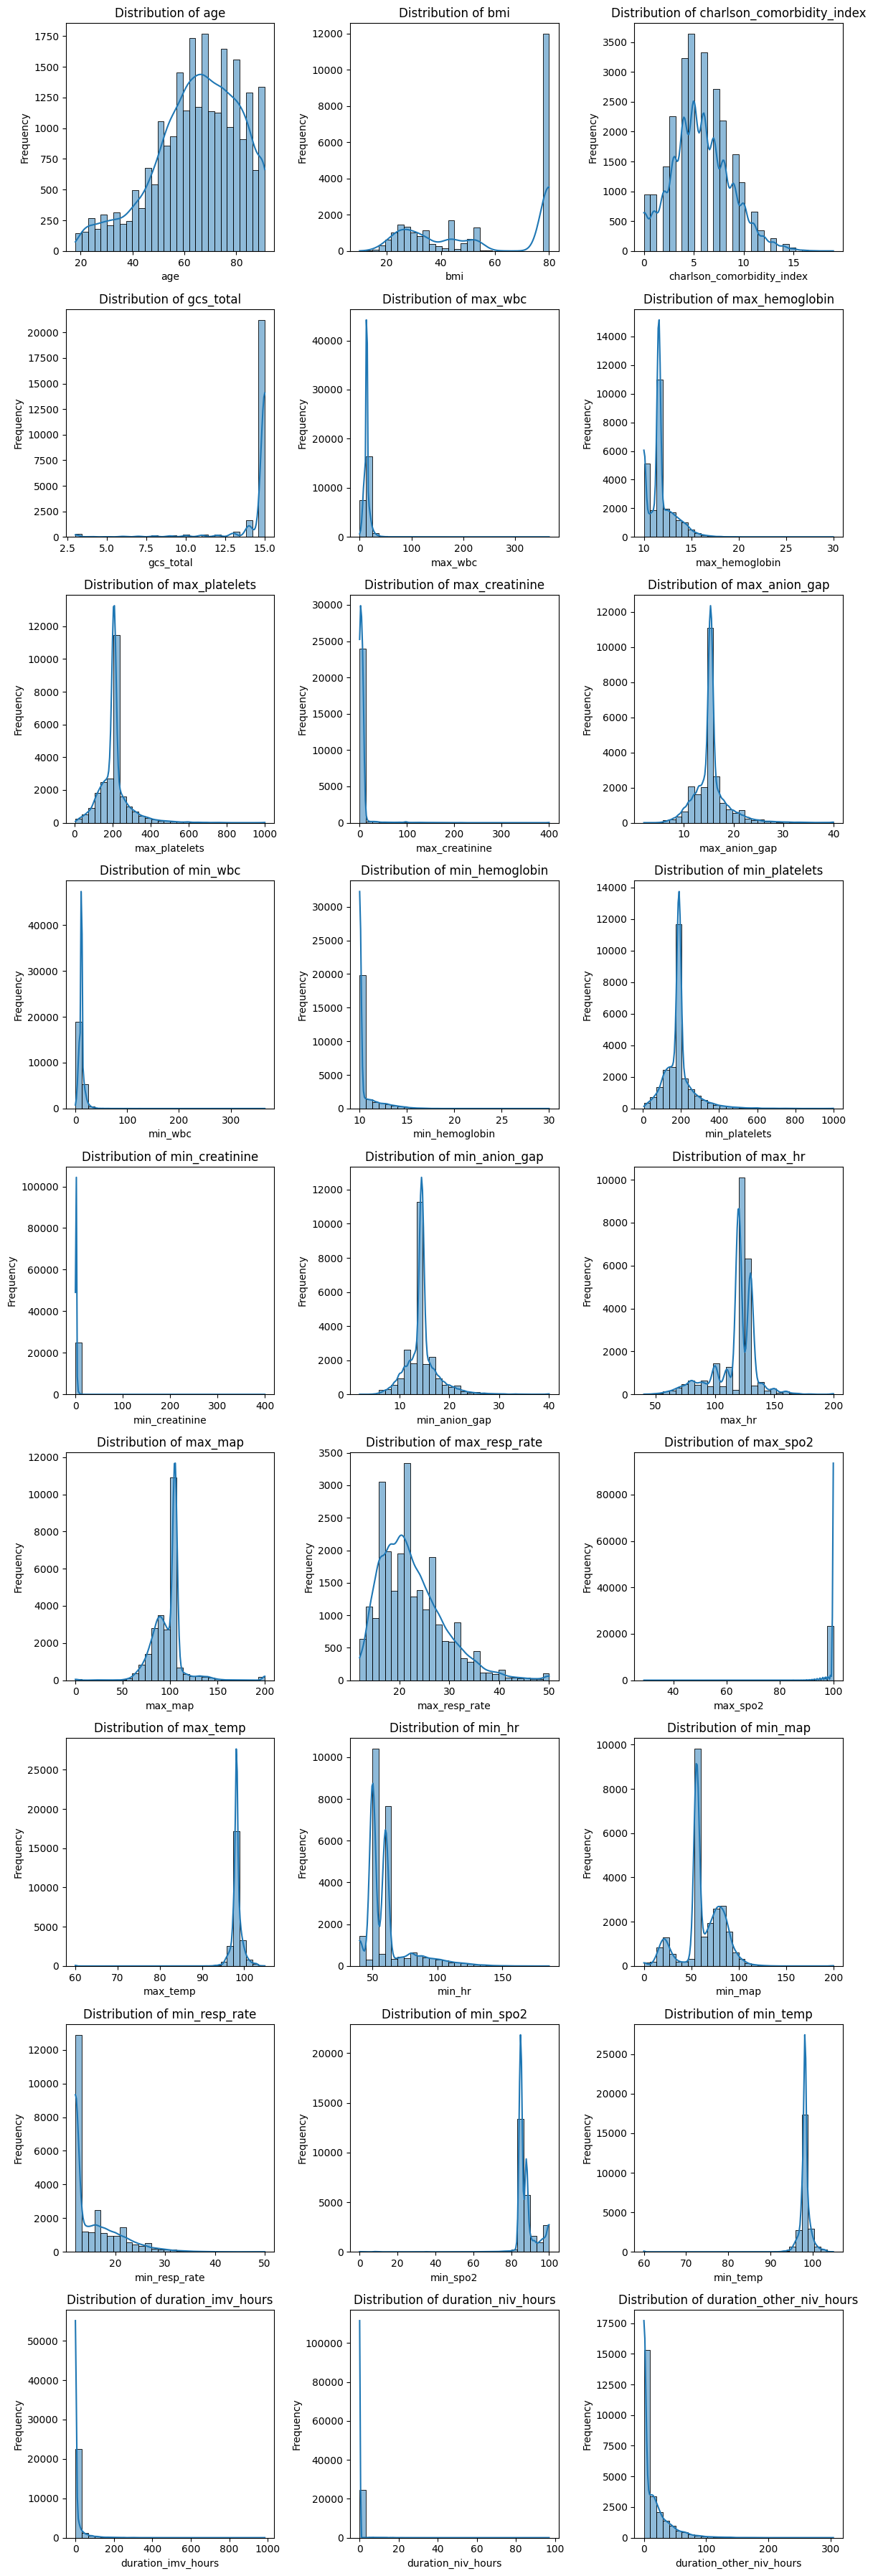

In [41]:
# Calculate the number of rows and columns for subplots based on the number of columns_to_check
n_cols = 3  # Set the number of columns for the subplot grid
n_rows = int(np.ceil(len(columns_to_check) / n_cols))  # Calculate rows needed

# Plot the distribution (histogram with KDE) for each column in 'columns_to_check'
plt.figure(figsize=(12, 4 * n_rows))
for i, column in enumerate(columns_to_check, 1):
    plt.subplot(n_rows, n_cols, i)  # Adjust rows and columns based on the number of columns
    sns.histplot(dfq1_cleaned_updated[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

None of the variables have a normal distribution

### __Correlation__

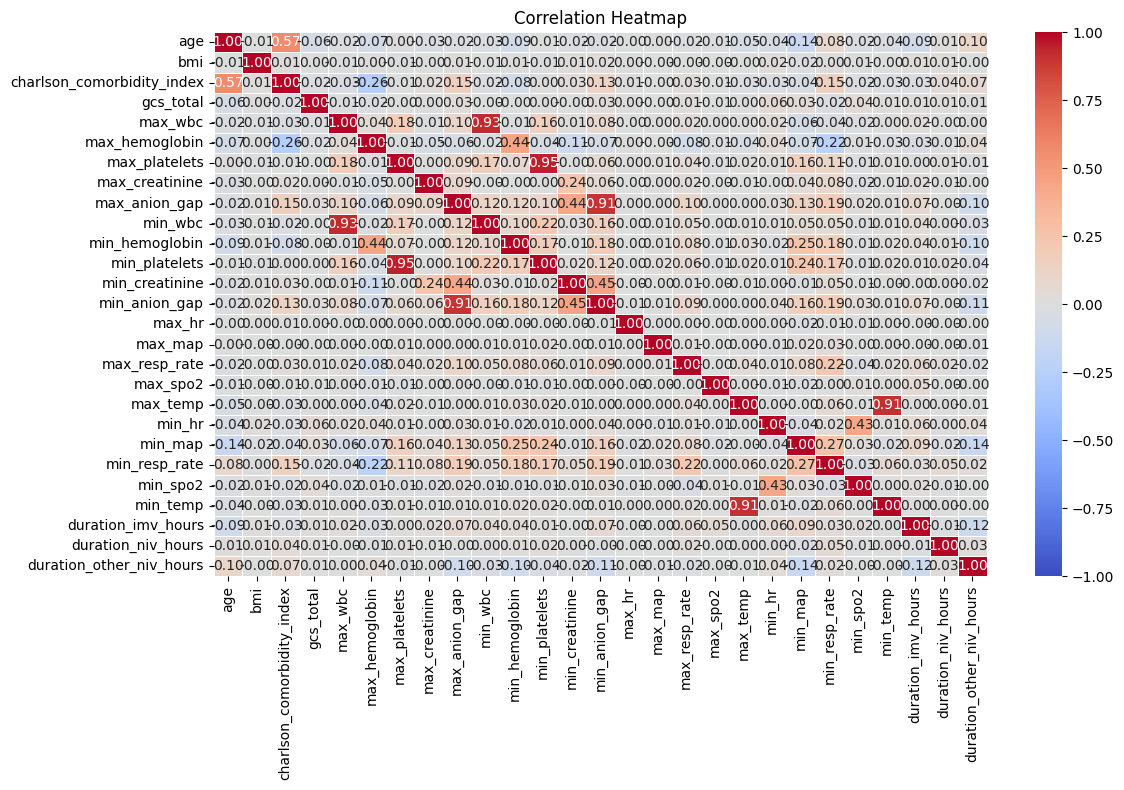

In [42]:
correlation_matrix = dfq1_cleaned[columns_to_check].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

### __Normality Check__

For the Normality Check, we will perform the Komolgorov Test:

In [55]:
from scipy.stats import kstest
for column in dfq1_cleaned[columns_to_check].columns:
    stat, p_value = kstest(dfq1_cleaned[columns_to_check][column].dropna(), 'norm')
    print(f"Kolmogorov-Smirnov Test for {column}: p-value = {p_value}")
    if p_value < 0.05:
        print(f"{column} is not normally distributed.")
    else:
        print(f"{column} is normally distributed.")


Kolmogorov-Smirnov Test for age: p-value = 0.0
age is not normally distributed.
Kolmogorov-Smirnov Test for bmi: p-value = 0.0
bmi is not normally distributed.
Kolmogorov-Smirnov Test for charlson_comorbidity_index: p-value = 0.0
charlson_comorbidity_index is not normally distributed.
Kolmogorov-Smirnov Test for gcs_total: p-value = 0.0
gcs_total is not normally distributed.
Kolmogorov-Smirnov Test for max_wbc: p-value = 0.0
max_wbc is not normally distributed.
Kolmogorov-Smirnov Test for max_hemoglobin: p-value = 0.0
max_hemoglobin is not normally distributed.
Kolmogorov-Smirnov Test for max_platelets: p-value = 0.0
max_platelets is not normally distributed.
Kolmogorov-Smirnov Test for max_creatinine: p-value = 0.0
max_creatinine is not normally distributed.
Kolmogorov-Smirnov Test for max_anion_gap: p-value = 0.0
max_anion_gap is not normally distributed.
Kolmogorov-Smirnov Test for min_wbc: p-value = 0.0
min_wbc is not normally distributed.
Kolmogorov-Smirnov Test for min_hemoglobin

### __Multicollinearity__

In [45]:
# Create a dataframe with only the numerical columns to check for multicollinearity
numerical_df = dfq1_cleaned_updated[columns_to_check]

# Add a constant to the dataframe (this is required for VIF calculation)
numerical_df_with_const = add_constant(numerical_df)

vif_data = pd.DataFrame()
vif_data["Variable"] = numerical_df_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(numerical_df_with_const.values, i) 
                   for i in range(numerical_df_with_const.shape[1])]
print(vif_data)

                      Variable          VIF
0                        const  7731.646956
1                          age     1.558225
2                          bmi     1.011720
3   charlson_comorbidity_index     1.576437
4                    gcs_total     1.010727
5                      max_wbc    11.189698
6               max_hemoglobin     2.104231
7                max_platelets    15.745569
8               max_creatinine     1.127851
9                max_anion_gap     6.706740
10                     min_wbc    11.498586
11              min_hemoglobin     2.232901
12               min_platelets    16.436898
13              min_creatinine     1.129285
14               min_anion_gap     6.919665
15                      max_hr     1.485851
16                     max_map     1.106077
17               max_resp_rate     1.486443
18                    max_spo2     1.320739
19                    max_temp     9.070813
20                      min_hr     1.578535
21                     min_map  

- max_platelets: 15.75. High VIF, suggesting potential multicollinearity.
- min_platelets: 16.44. Similarly high VIF, indicating possible correlation with other platelet-related variables.
- max_temp and min_temp: Both have VIFs around 9, which suggests moderate multicollinearity.
- max_wbc and min_wbc: Both have VIFs around 11. This also suggests potential issues with multicollinearity related to white blood cell counts.

We take in notice that the columns of min and max are correlated with one another

Finally let's export the final dataset:

In [46]:
dfq1_cleaned_updated.to_csv('final_cleaned_dataset.csv', index=False)
print("Dataset has been exported as 'final_cleaned_dataset.csv'.")

Dataset has been exported as 'final_cleaned_dataset.csv'.


In [47]:
df = pd.read_csv('/Users/karibautista/Desktop/DANA 4830/Team work/Query 1/final_cleaned_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24880 entries, 0 to 24879
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   subject_id                  24880 non-null  int64  
 1   stay_id                     24880 non-null  int64  
 2   age                         24880 non-null  int64  
 3   gender                      24880 non-null  object 
 4   bmi                         24880 non-null  float64
 5   charlson_comorbidity_index  24880 non-null  int64  
 6   chronic_pulmonary_disease   24880 non-null  int64  
 7   congestive_heart_failure    24880 non-null  int64  
 8   dementia                    24880 non-null  int64  
 9   severe_liver_disease        24880 non-null  int64  
 10  renal_disease               24880 non-null  int64  
 11  rheumatic_disease           24880 non-null  int64  
 12  diabetes                    24880 non-null  int64  
 13  gcs_total                   248

### __Balance Data Check__

Before going into the Data Processing, let's see if our target variables are balanced:

In [48]:
weaning_success_counts = df['weaning_success'].value_counts()
weaning_success_percentage = weaning_success_counts / len(df) * 100
print("\nweaning_success percentage:")
print(weaning_success_percentage)


weaning_success percentage:
weaning_success
1    73.291801
0    26.708199
Name: count, dtype: float64


The target variable "weaning_success" is imbalanced, with only 27% of the data indicating that patients are undergoing dialysis. This needs to be addressed. For the models, we will be assigning Class Weights.

### __Train and test__

We will be applying the __XGBoost__ and __Random Forest__ models to our data following the Exploratory Data Analysis (EDA)

In [49]:
df['gender'] = df['gender'].map({'M': 1, 'F': 0}) # Note tha gender is F or M, so we run this code to replace M=1 and F=0
X1 = df.drop(columns=['subject_id', 'stay_id','weaning_success','age_group'])
y1 = df['weaning_success']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled1 = scaler.fit_transform(X_train1)  # Fit on training data and transform
X_test_scaled1 = scaler.transform(X_test1) 

In [50]:
print(X_train1.shape)  # This should be (number_of_samples, 35)
print(X_test1.shape) 

(19904, 35)
(4976, 35)


### __XGBoost Logistic__

In [56]:
# Compute class weights based on the target distribution
class_weights = np.bincount(y_train1)  # Count of each class (0 and 1)
scale_pos_weight = class_weights[0] / class_weights[1]  # Ratio of negative to positive class

# Create the XGBoost model with scale_pos_weight to address class imbalance
model_xgb = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)

# Train the model
model_xgb.fit(X_train_scaled1, y_train1)

# Make predictions on the test set
y_pred_xgb = model_xgb.predict(X_test_scaled1)
y_pred_proba = model_xgb.predict_proba(X_test_scaled1)[:, 1]

### __Random Forest__

In [57]:
model2 = RandomForestClassifier(class_weight='balanced', random_state=42)
model2.fit(X_train_scaled1, y_train1)
y_pred2 = model2.predict(X_test_scaled1)

### __PCA__

In [58]:
# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled1)  # Fit on training data and transform it
X_test_pca = pca.transform(X_test_scaled1)  # Transform the test data based on the training PCA

# Check the number of components retained
print(f"Number of components after PCA: {X_train_pca.shape[1]}")

Number of components after PCA: 27


- __XGBoost__

In [59]:
class_weights = np.bincount(y_train1)  # Count of each class (0 and 1)
scale_pos_weight = class_weights[0] / class_weights[1]  # Ratio of negative to positive class

# Create the XGBoost model with scale_pos_weight to address class imbalance
model_xgb_pca = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)

# Train the XGBoost model using the PCA-transformed data
model_xgb_pca.fit(X_train_pca, y_train1)
y_pred_xgb_pca = model_xgb_pca.predict(X_test_pca)

- __Random Forest__

In [60]:
# Train RandomForest model with PCA data
model2_pca = RandomForestClassifier(class_weight='balanced', random_state=42)
model2_pca.fit(X_train_pca, y_train1)

# Make predictions on the PCA-transformed test data
y_pred2_pca = model2_pca.predict(X_test_pca)

### __Gridsearch__

- __XGBoost Model__

In [61]:
X2 = df.drop(columns=['subject_id', 'stay_id', 'weaning_success', 'age_group'])
y2 = df['weaning_success']

# Train-test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Feature scaling (optional, as XGBoost is not very sensitive to scaling)r
scaler = StandardScaler()
X_train_scaled2 = scaler.fit_transform(X_train2)
X_test_scaled2 = scaler.transform(X_test2)

# Compute class weights to balance the class distribution
import numpy as np
class_weights = np.bincount(y_train2)  # Count of each class (0 and 1)
scale_pos_weight = class_weights[0] / class_weights[1]  # Ratio of negative to positive class

# Create the base XGBoost model (removing the deprecated use_label_encoder parameter)
import xgboost as xgb
xgb_model2 = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, 
                               eval_metric='logloss')

# Define hyperparameter grid for GridSearchCV
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],               # Number of boosting rounds
    'max_depth': [3, 6, 10],                        # Maximum depth of the tree
    'learning_rate': [0.01, 0.1, 0.2],              # Learning rate (step size)
    'subsample': [0.8, 1.0],                        # Proportion of samples used for each tree
    'colsample_bytree': [0.8, 1.0],                 # Proportion of features used for each tree
    'gamma': [0, 1, 5],                             # Regularization term
    'min_child_weight': [1, 5, 10],                  # Minimum sum of instance weight (hessian) needed in a child
}

# Perform GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_model2, param_grid=param_grid, cv=3, 
                           scoring='f1', n_jobs=-1, verbose=2)

# Fit the model to find the best hyperparameters
grid_search.fit(X_train_scaled2, y_train2)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model from GridSearchCV
best_xgb_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred_xgb2 = best_xgb_model.predict(X_test_scaled2)

# Evaluate the model performance
from sklearn.metrics import classification_report
print(classification_report(y_test2, y_pred_xgb2))

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_de

- __Random Forest__

In [62]:
rf_model2 = RandomForestClassifier(class_weight='balanced', random_state=42)

# Define hyperparameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],              # Number of trees in the forest
    'max_depth': [3, 6, 10, None],                 # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],               # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],                 # Minimum samples required at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],     # Number of features to consider at each split
    'bootstrap': [True, False],                    # Whether to use bootstrap samples
    'class_weight': ['balanced', None],            # Class weights to handle imbalance
    'max_samples': [None, 0.8]                     # Fraction of samples to use for training
}

# Perform GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_model2, param_grid=param_grid, cv=3, 
                              scoring='f1', n_jobs=-1, verbose=2)

# Fit the model to find the best hyperparameters
grid_search_rf.fit(X_train_scaled2, y_train2)

# Print the best hyperparameters
print("Best Hyperparameters for Random Forest:", grid_search_rf.best_params_)

# Get the best model from GridSearchCV
best_rf_model = grid_search_rf.best_estimator_

# Make predictions using the best model
y_pred_rf2 = best_rf_model.predict(X_test_scaled2)

# Evaluate the model performance
print(classification_report(y_test2, y_pred_rf2))

Fitting 3 folds for each of 2592 candidates, totalling 7776 fits
[CV] END bootstrap=True, class_weight=balanced, max_depth=3, max_features=auto, max_samples=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=3, max_features=auto, max_samples=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=3, max_features=auto, max_samples=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=3, max_features=auto, max_samples=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=3, max_features=auto, max_samples=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_dep

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
3888 fits failed out of a total of 7776.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
679 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3

Best Hyperparameters for Random Forest: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'max_samples': 0.8, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1327
           1       0.97      1.00      0.98      3649

    accuracy                           0.98      4976
   macro avg       0.98      0.96      0.97      4976
weighted avg       0.98      0.98      0.98      4976



### __SHAP__

SHAP (Shapley Additive Explanations) is a method used to explain the results of machine learning models, especially complex ones. In this section, we'll apply SHAP to our model to identify which features are the most important.

For __XGBoost__ model:

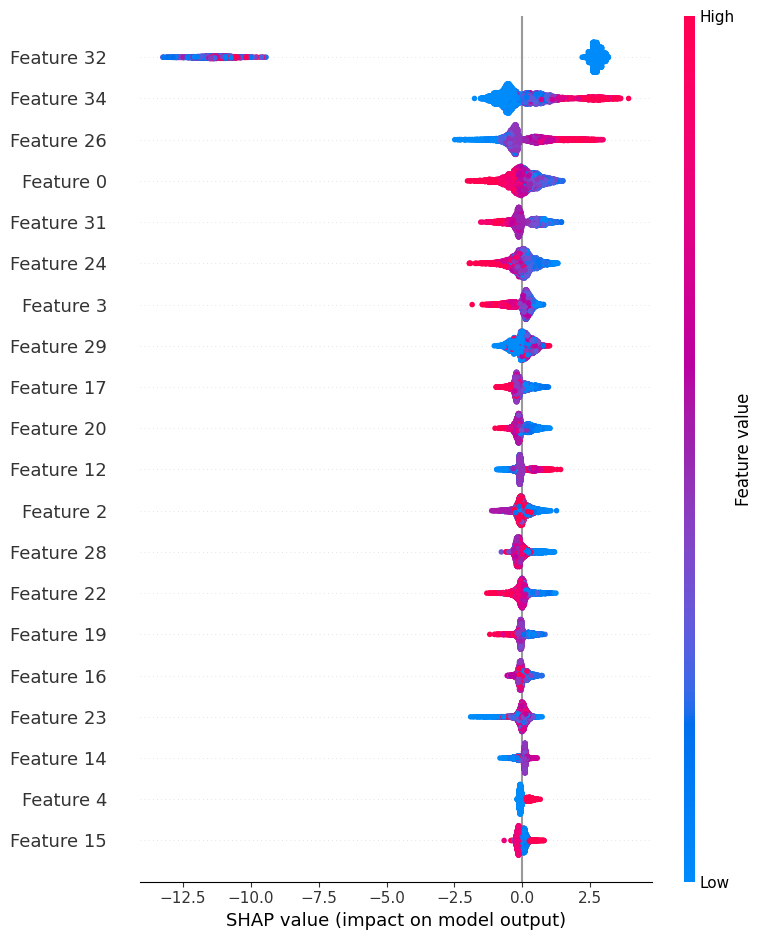

In [63]:
# Create a SHAP explainer using the trained model
explainer1 = shap.Explainer(model_xgb, X_train_scaled1)

# Get SHAP values for the test set
shap_values1 = explainer1(X_test_scaled1)

# Visualize the SHAP values for the first prediction
shap.initjs()  # Initialize JavaScript visualization in Jupyter Notebook
shap.force_plot(shap_values1[0])  # Display the force plot for the first instance

# Visualize the feature importance
shap.summary_plot(shap_values1, X_test_scaled1)

In [64]:
# Create feature importance dataframe
feature_importance = pd.DataFrame(list(zip(df.columns, shap_values1.values.mean(axis=0))),
                                  columns=['Feature', 'Importance'])

# Sort the features by importance
feature_importance_sorted = feature_importance.sort_values(by='Importance', ascending=False)

# Get the most important features (you can adjust the number of features here)
most_important_features = feature_importance_sorted['Feature'].head()  # Top N features
print("Most important features:")
print(most_important_features)

Most important features:
34            duration_imv_hours
5     charlson_comorbidity_index
31                 min_resp_rate
10                 renal_disease
3                         gender
Name: Feature, dtype: object


In [65]:
important_features = ['duration_imv_hours', 'charlson_comorbidity_index', 'min_resp_rate', 
                      'renal_disease', 'gender']

X3 = df[important_features]
y3 = df['weaning_success']

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled3 = scaler.fit_transform(X_train3)  # Fit on training data and transform
X_test_scaled3 = scaler.transform(X_test3)  # Transform test data using the same scaler

# Calculate class weights to address class imbalance
class_weights3 = np.bincount(y_train3)  # Count of each class (0 and 1)
scale_pos_weight3 = class_weights3[0] / class_weights3[1]  # Ratio of negative to positive class

# Create the XGBoost model with scale_pos_weight to address class imbalance
features_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight3, random_state=42)

# Train the XGBoost model
features_model.fit(X_train_scaled3, y_train3)

# Predict on the test data
y_pred_features_model = features_model.predict(X_test_scaled3)
y_prob_features_model = features_model.predict_proba(X_test_scaled3)[:, 1]  # Probabilities for AUC-ROC


### __Results__

- The __original__ model with __XGBoost__

In [66]:
accuracy1 = accuracy_score(y_test1, y_pred_xgb)
auc_roc1 = roc_auc_score(y_test1, y_pred_proba)
conf_matrix1 = confusion_matrix(y_test1, y_pred_xgb)
class_report1 = classification_report(y_test1, y_pred_xgb)

print(f"Accuracy: {accuracy1:.4f}")
print("Confusion Matrix:")
print(conf_matrix1)
print("Classification Report:")
print(class_report1)
print(f"AUC-ROC: {auc_roc1:.4f}")


Accuracy: 0.9731
Confusion Matrix:
[[1221  106]
 [  28 3621]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1327
           1       0.97      0.99      0.98      3649

    accuracy                           0.97      4976
   macro avg       0.97      0.96      0.96      4976
weighted avg       0.97      0.97      0.97      4976

AUC-ROC: 0.9827


- The __original__ model with __Random Forest__

In [67]:
accuracy22 = accuracy_score(y_test1, y_pred2)
conf_matrix22 = confusion_matrix(y_test1, y_pred2)
class_report22 = classification_report(y_test1, y_pred2)
y_pred_proba22 = model2.predict_proba(X_test_scaled1)[:, 1]  # Get probabilities for class 1
auc_roc22 = roc_auc_score(y_test1, y_pred_proba22)  # Corrected here

print(f"Random Forest Accuracy: {accuracy22}")
print(f"Random Forest Confusion Matrix:\n{conf_matrix22}")
print(f"Random Forest Classification Report:\n{class_report22}")
print(f"Random Forest AUC-ROC: {auc_roc22}")

Random Forest Accuracy: 0.9758842443729904
Random Forest Confusion Matrix:
[[1207  120]
 [   0 3649]]
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1327
           1       0.97      1.00      0.98      3649

    accuracy                           0.98      4976
   macro avg       0.98      0.95      0.97      4976
weighted avg       0.98      0.98      0.98      4976

Random Forest AUC-ROC: 0.9820915930555036


- __PCA__ with __XGBoost__ Model

In [68]:
accuracy_xgb_pca = accuracy_score(y_test1, y_pred_xgb_pca)
conf_matrix_xgb_pca = confusion_matrix(y_test1, y_pred_xgb_pca)
class_report_xgb_pca = classification_report(y_test1, y_pred_xgb_pca)
y_pred_proba_xgb_pca = model_xgb_pca.predict_proba(X_test_pca)[:, 1]  # Get probabilities for class 1
auc_roc_xgb_pca = roc_auc_score(y_test1, y_pred_proba_xgb_pca)

print(f"XGBoost Accuracy (PCA): {accuracy_xgb_pca}")
print(f"XGBoost Confusion Matrix (PCA):\n{conf_matrix_xgb_pca}")
print(f"XGBoost Classification Report (PCA):\n{class_report_xgb_pca}")
print(f"XGBoost AUC-ROC (PCA): {auc_roc_xgb_pca}")

XGBoost Accuracy (PCA): 0.9071543408360129
XGBoost Confusion Matrix (PCA):
[[ 969  358]
 [ 104 3545]]
XGBoost Classification Report (PCA):
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1327
           1       0.91      0.97      0.94      3649

    accuracy                           0.91      4976
   macro avg       0.91      0.85      0.87      4976
weighted avg       0.91      0.91      0.90      4976

XGBoost AUC-ROC (PCA): 0.9200402377172634


- __PCA__ with __Random Forest__ Model

In [69]:
accuracy2_pca = accuracy_score(y_test1, y_pred2_pca)
conf_matrix2_pca = confusion_matrix(y_test1, y_pred2_pca)
class_report2_pca = classification_report(y_test1, y_pred2_pca)
y_pred_proba2_pca = model2_pca.predict_proba(X_test_pca)[:, 1]
auc_roc2_pca = roc_auc_score(y_test1, y_pred_proba2_pca)

print(f"Random Forest Accuracy (PCA): {accuracy2_pca}")
print(f"Random Forest Confusion Matrix (PCA):\n{conf_matrix2_pca}")
print(f"Random Forest Classification Report (PCA):\n{class_report2_pca}")
print(f"Random Forest AUC-ROC (PCA): {auc_roc2_pca}")

Random Forest Accuracy (PCA): 0.8530948553054662
Random Forest Confusion Matrix (PCA):
[[ 608  719]
 [  12 3637]]
Random Forest Classification Report (PCA):
              precision    recall  f1-score   support

           0       0.98      0.46      0.62      1327
           1       0.83      1.00      0.91      3649

    accuracy                           0.85      4976
   macro avg       0.91      0.73      0.77      4976
weighted avg       0.87      0.85      0.83      4976

Random Forest AUC-ROC (PCA): 0.8817158978427884


- __Gridsearch__ with __XGBoost__ model

In [70]:
accuracy2 = accuracy_score(y_test2, y_pred_xgb2)
conf_matrix2 = confusion_matrix(y_test2, y_pred_xgb2)
class_report2 = classification_report(y_test2, y_pred_xgb2)
y_pred_prob_xgb2 = best_xgb_model.predict_proba(X_test_scaled2)[:, 1]  # For AUC-ROC
auc_roc2 = roc_auc_score(y_test2, y_pred_prob_xgb2)

# Now print the results
print(f"XGBoost Accuracy: {accuracy2}")
print(f"XGBoost Confusion Matrix:\n{conf_matrix2}")
print(f"XGBoost Classification Report:\n{class_report2}")
print(f"XGBoost AUC-ROC: {auc_roc2}")

XGBoost Accuracy: 0.9758842443729904
XGBoost Confusion Matrix:
[[1207  120]
 [   0 3649]]
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1327
           1       0.97      1.00      0.98      3649

    accuracy                           0.98      4976
   macro avg       0.98      0.95      0.97      4976
weighted avg       0.98      0.98      0.98      4976

XGBoost AUC-ROC: 0.9832808195739849


- __Gridsearch__ with __Random Forest__ model

In [71]:
accuracy_rf2 = accuracy_score(y_test2, y_pred_rf2)

# Confusion Matrix
conf_matrix_rf2 = confusion_matrix(y_test2, y_pred_rf2)

# Classification Report
class_report_rf2 = classification_report(y_test2, y_pred_rf2)

# AUC-ROC (For this, we need probabilities of class 1)
y_pred_proba_rf2 = best_rf_model.predict_proba(X_test_scaled2)[:, 1]  # Probabilities for class 1
auc_roc_rf2 = roc_auc_score(y_test2, y_pred_proba_rf2)

# Print the results
print(f"Random Forest Accuracy: {accuracy_rf2}")
print(f"Random Forest Confusion Matrix:\n{conf_matrix_rf2}")
print(f"Random Forest Classification Report:\n{class_report_rf2}")
print(f"Random Forest AUC-ROC: {auc_roc_rf2}")

Random Forest Accuracy: 0.9758842443729904
Random Forest Confusion Matrix:
[[1209  118]
 [   2 3647]]
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1327
           1       0.97      1.00      0.98      3649

    accuracy                           0.98      4976
   macro avg       0.98      0.96      0.97      4976
weighted avg       0.98      0.98      0.98      4976

Random Forest AUC-ROC: 0.9848001630656001


- __SHAP__ with __XGBoost__ model

In [72]:
accuracy4 = accuracy_score(y_test3, y_pred_features_model)
conf_matrix4 = confusion_matrix(y_test3, y_pred_features_model)
class_report4 = classification_report(y_test3, y_pred_features_model)
auc_roc4 = roc_auc_score(y_test3, y_prob_features_model)

# Print the results
print("Accuracy: ", accuracy4)
print("\nConfusion Matrix:")
print(conf_matrix4)
print("\nClassification Report:\n", class_report4)
print("AUC-ROC: ", auc_roc4)

Accuracy:  0.9734726688102894

Confusion Matrix:
[[1208  119]
 [  13 3636]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.91      0.95      1327
           1       0.97      1.00      0.98      3649

    accuracy                           0.97      4976
   macro avg       0.98      0.95      0.97      4976
weighted avg       0.97      0.97      0.97      4976

AUC-ROC:  0.9661688443510347


### __Final Results__

| Model                          | Accuracy      | Confusion Matrix                                          | AUC-ROC          | Classification Report                                                                                                      |
|--------------------------------|---------------|-----------------------------------------------------------|------------------|----------------------------------------------------------------------------------------------------------------------------|
| Original XGBoost Model         | 0.9731        | [[1221  106], [  28  3621]]                               | 0.9827           | Precision: 0.97, Recall: 0.92, F1-score: 0.95 for class 0, Precision: 0.97, Recall: 0.99, F1-score: 0.98 for class 1          |
| Original Random Forest Model   | 0.9759        | [[1207  120], [   0  3649]]                               | 0.9821           | Precision: 1.00, Recall: 0.91, F1-score: 0.95 for class 0, Precision: 0.97, Recall: 1.00, F1-score: 0.98 for class 1          |
| XGBoost (PCA)                  | 0.9072        | [[ 969  358], [ 104  3545]]                               | 0.9200           | Precision: 0.90, Recall: 0.73, F1-score: 0.81 for class 0, Precision: 0.91, Recall: 0.97, F1-score: 0.94 for class 1          |
| Random Forest (PCA)            | 0.8531        | [[ 608  719], [  12  3637]]                               | 0.8817           | Precision: 0.98, Recall: 0.46, F1-score: 0.62 for class 0, Precision: 0.83, Recall: 1.00, F1-score: 0.91 for class 1          |
| XGBoost (GridSearch)           | 0.9759        | [[1207  120], [   0  3649]]                               | 0.9833           | Precision: 1.00, Recall: 0.91, F1-score: 0.95 for class 0, Precision: 0.97, Recall: 1.00, F1-score: 0.98 for class 1          |
| Random Forest (GridSearch)     | 0.9759        | [[1209  118], [   2  3647]]                               | 0.9848           | Precision: 1.00, Recall: 0.91, F1-score: 0.95 for class 0, Precision: 0.97, Recall: 1.00, F1-score: 0.98 for class 1          |
| SHAP                            | 0.9735        | [[1208  119], [  13  3636]]                               | 0.9662           | Precision: 0.99, Recall: 0.91, F1-score: 0.95 for class 0, Precision: 0.97, Recall: 1.00, F1-score: 0.98 for class 1          |

Since my target variable is weaning_success, which is a critical medical outcome indicating whether the procedure was successful, we want to focus on correctly identifying patients who had a successful weaning process (the positive class, typically labeled as 1). Thus, the model needs to prioritize minimizing false negatives (the model incorrectly predicting that a patient did not have a successful weaning procedure when they actually did) and maximizing recall (sensitivity) to ensure that most of the patients who actually had successful weaning are identified.

_Original XGBoost Model:_
- True Positives (TP): 3617
- False Negatives (FN): 32
- Observation: This model correctly identifies 3617 successful weaning cases (TP), but it also has 32 false negatives (FN). While this is a relatively low number of missed successful cases, it still means that 32 patients who had successful weaning are overlooked, which could lead to missed diagnoses in a medical setting.

_Original Random Forest Model:_
- True Positives (TP): 3649
- False Negatives (FN): 0
- Observation: This model has no false negatives, meaning it correctly identifies all successful weaning cases (TP = 3649). There are no missed successful weaning cases, which is ideal for a medical setting. This model provides perfect detection of successful cases.

_XGBoost (PCA):_
- True Positives (TP): 3545
- False Negatives (FN): 104
- Observation: This model has 3545 true positives (TP), but 104 false negatives (FN). It misses 104 successful weaning cases, which is a significant number. In a medical context, these missed cases could be critical, and this number of false negatives should be a point of concern, as it means 104 patients who actually had a successful weaning are being incorrectly flagged as unsuccessful.

_Random Forest (PCA):_
- True Positives (TP): 3637
- False Negatives (FN): 12
- Observation: This model identifies 3637 successful weaning cases (TP) but misses 12 successful cases (FN). While the number of false negatives is relatively small, 12 missed cases can still be problematic in a medical setting, though this is much better than some other models.

_XGBoost (GridSearch):_
- True Positives (TP): 3649
- False Negatives (FN): 0
- Observation: Similar to the original Random Forest model, this model correctly identifies all successful weaning cases, with no false negatives (FN = 0). It performs perfectly in detecting all successful cases, which is excellent for medical applications.

_Random Forest (GridSearch):_
- True Positives (TP): 3647
- False Negatives (FN): 2
- Observation: This model has 3647 true positives (TP) and only 2 false negatives (FN). This is a very low number of missed successful weaning cases, and the model is almost perfect in identifying successful cases.

_SHAP XGBoost:_
- True Positives (TP): 3636
- False Negatives (FN): 13
Observation: This model identifies 3636 successful weaning cases (TP) but misses 13 successful weaning cases (FN). While the number of missed cases is low, it still represents missed diagnoses that could impact patient care.

Models with perfect recall (0 FN):
- Original Random Forest: No false negatives (FN = 0), identifying all successful weaning cases (TP = 3649).
- XGBoost (GridSearch): No false negatives (FN = 0), correctly identifying all successful cases (TP = 3649).

These models are ideal for detecting successful weaning, as they do not miss any successful cases (i.e., no false negatives).

### __References__

Liu, W., Tao, G., Zhang, Y., Xiao, W., Zhang, J., Liu, Y., Lu, Z., Hua, T. and Yang, M. (2022). A Simple Weaning Model Based on Interpretable Machine Learning Algorithm for Patients With Sepsis: A Research of MIMIC-IV and eICU Databases. Frontiers in Medicine, 8. doi:https://doi.org/10.3389/fmed.2021.814566.